In [1]:
# Сделать сравнение с отбором фич из склерн и попробовать отбирать объекты своим методом

### https://towardsdatascience.com/logistic-regression-classifier-on-census-income-data-e1dbef0b5738

## Подготовка данных

In [2]:
import numpy as np
import pandas as pd
import io
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import os
from pandas.api.types import CategoricalDtype
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn
from sklearn.decomposition import PCA
%matplotlib inline

In [3]:
def load_dataset(path, urls):
    if not os.path.exists(path):
        os.mkdir(path)

    for url in urls:
        data = requests.get(url).content
        filename = os.path.join(path, os.path.basename(url))
        with open(filename, "wb") as file:
            file.write(data)

In [4]:
columns = ["age", "workClass", "fnlwgt", "education", "education-num","marital-status", "occupation", "relationship",
          "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
train_data = pd.read_csv('adult/adult.data', names=columns, 
             sep=' *, *', na_values='?')
test_data  = pd.read_csv('adult/adult.test', names=columns, 
             sep=' *, *', skiprows=1, na_values='?')

C:\Users\Irina\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
C:\Users\Irina\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workClass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    31978 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
num_attributes = train_data.select_dtypes(include=['int64'])
print(num_attributes.columns)

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


In [7]:
#num_attributes.hist(figsize=(10,10))

In [8]:
cat_attributes = train_data.select_dtypes(include=['object'])
print(cat_attributes.columns)

Index(['workClass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'income'],
      dtype='object')


In [9]:
#sns.countplot(y='workClass', hue='income', data = cat_attributes)

In [10]:
#sns.countplot(y='occupation', hue='income', data = cat_attributes)

In [11]:
class ColumnsSelector(BaseEstimator, TransformerMixin):
    def __init__(self, type):
        self.type = type
  
    def fit(self, X, y=None):
        return self
  
    def transform(self,X):
        return X.select_dtypes(include=[self.type])

In [12]:
num_pipeline = Pipeline(steps=[
    ("num_attr_selector", ColumnsSelector(type='int64')),
    ("scaler", StandardScaler())
])

In [13]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
  
    def __init__(self, columns = None, strategy='most_frequent'):
        self.columns = columns
        self.strategy = strategy
    
    
    def fit(self,X, y=None):
        if self.columns is None:
            self.columns = X.columns

        if self.strategy is 'most_frequent':
            self.fill = {column: X[column].value_counts().index[0] for column in self.columns}
        else:
            self.fill ={column: '0' for column in self.columns}
      
        return self
      
    def transform(self,X):
        X_copy = X.copy()
        for column in self.columns:
            X_copy[column] = X_copy[column].fillna(self.fill[column])
        return X_copy

In [14]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
    def __init__(self, dropFirst=True):
        self.categories=dict()
        self.dropFirst=dropFirst
    
    def fit(self, X, y=None):
        join_df = pd.concat([train_data, test_data])
        join_df = join_df.select_dtypes(include=['object'])
        for column in join_df.columns:
            self.categories[column] = join_df[column].value_counts().index.tolist()
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.select_dtypes(include=['object'])
        for column in X_copy.columns:
            X_copy[column] = X_copy[column].astype({column: CategoricalDtype(self.categories[column])})
        return pd.get_dummies(X_copy, drop_first=self.dropFirst)

In [15]:
cat_pipeline = Pipeline(steps=[
    ("cat_attr_selector", ColumnsSelector(type='object')),
    ("cat_imputer", CategoricalImputer(columns=
          ['workClass','occupation', 'native-country'])),
    ("encoder", CategoricalEncoder(dropFirst=True))
])

In [16]:
full_pipeline = FeatureUnion([("num_pipe", num_pipeline), ("cat_pipeline", cat_pipeline)])

In [17]:
train_data.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [18]:
train_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)
test_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)

In [19]:
train_copy = train_data.copy()
train_copy["income"] = train_copy["income"].apply(lambda x:0 if 
                        x=='<=50K' else 1)
X_train = train_copy.drop('income', axis =1)
Y_train = train_copy['income']

In [20]:
X_train_processed=full_pipeline.fit_transform(X_train)

In [21]:
X_train_processed.shape

(32561, 81)

In [22]:
test_copy = test_data.copy()
test_copy["income"] = test_copy["income"].apply(lambda x:0 if 
                      x=='<=50K.' else 1)
X_test = test_copy.drop('income', axis =1)
Y_test = test_copy['income']

In [23]:
X_test_processed = full_pipeline.fit_transform(X_test)

## Вычислительный эксперимент

In [24]:
import numpy as np
np.random.seed(seed=42)
import pandas as pd
import itertools


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import copy
import math

import matplotlib
import matplotlib.pyplot as plt

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

pd.set_option('display.float_format','{:,.5f}'.format)
pd.set_option('display.max_columns', None)
from IPython import display

In [26]:
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
# %config InlineBackend.figure_format = 'svg' 
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['figure.figsize'] = [7, 5]
### Сохранение изображения ###
plt.savefig('1.svg') # Поддерживаемые форматы: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff

<Figure size 504x360 with 0 Axes>

In [27]:
from utils import *
from logreg import *

<Figure size 504x360 with 0 Axes>

In [28]:
df = pd.DataFrame(X_train_processed)
outliers_removed, outliers = remove_outliers(df.iloc[:, :4])
X_train_processed = np.array(df.loc[outliers_removed])
Y_train = Y_train[outliers_removed]
X_train_processed.shape, Y_train.shape

((28438, 81), (28438,))

In [29]:
X = X_train_processed[:, :30]
T = np.array(Y_train)
X_test = X_test_processed[:, :30]
Y_test = np.array(Y_test)

In [30]:
# write
%store X
%store T
%store X_test
%store Y_test

Stored 'X' (ndarray)
Stored 'T' (ndarray)
Stored 'X_test' (ndarray)
Stored 'Y_test' (ndarray)


In [31]:
# read
%store -r X
%store -r T
%store -r X_test
%store -r Y_test

In [31]:
# [-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
#  -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
#  -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
#  -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
#  -0.02122398 -0.02894507]
# feat_threshold=1e+21

In [32]:
# Еще одни хорошие веса 
# [-0.00322571  0.00808102  0.03772372  0.00349156  0.00515101 -0.00148892
#  -0.03837542 -0.00053028  0.0012046   0.04926484 -0.00384722  0.00603095
#  -0.00069424 -0.02337356  0.02285646  0.01503866  0.01582064 -0.01818775
#   0.02805589 -0.02803702  0.01173714  0.04380911 -0.01981073 -0.01132595
#   0.00199303 -0.01006951]
# feat_threshold=1e+20

In [189]:
from logreg import *
clf = SuperpositionModel()

In [190]:
clf.w

In [45]:
w.std()

0.021305077225157818

In [52]:
1/37

0.02702702702702703

In [50]:
b = math.sqrt(3/37)

In [51]:
4*b*b/12

0.027027027027027032

In [34]:
# w = np.array([-0.03650337, -0.0107314,  -0.00234493, -0.00433932, -0.03974928, -0.02914917,
#  -0.01633966, -0.00345402, -0.03254841, -0.0266781,  -0.04509162, -0.04688906,
#  -0.00671441,  0.00415988, -0.02440513, -0.00289427, -0.0157322,  -0.03586732,
#  -0.01573701,  0.00779581, -0.02368145,  0.00832795, -0.07535983, -0.00652688,
#  -0.02122398, -0.02894507, -0.02633966, -0.04345402, -0.03254841, -0.0666781,
#  -0.0033966,  -0.079402,   -0.03254841, -0.04301776, -0.0053454,  -0.0053454,
#  -0.01671441])
# clf.set_weights(w)
# len(w)

37

In [57]:
w = np.random.uniform(b, -b, 37)
w.std()

0.1542202791555294

In [191]:
clf.set_weights(w)
len(w)

28

In [63]:
from scipy.stats import uniform

In [186]:
vals = uniform.rvs(loc=-b, scale=0.0905, size=37, random_state=None)

In [187]:
vals

array([-0.27015687, -0.20060976, -0.2116125 , -0.22742436, -0.20588022,
       -0.21201508, -0.26786281, -0.20397081, -0.23593693, -0.21167406,
       -0.20365114, -0.25596808, -0.2747877 , -0.26411927, -0.24609414,
       -0.21071706, -0.20685128, -0.28411823, -0.23852477, -0.2469717 ,
       -0.26464664, -0.27389958, -0.25419323, -0.19941407, -0.25549753,
       -0.23779685, -0.22112418, -0.25183892, -0.19680112, -0.19764592,
       -0.2619611 , -0.23974641, -0.25751791, -0.25896933, -0.28140913,
       -0.22958183, -0.23925495])

In [188]:
vals.std()

0.026727967669370346

In [192]:
clf.set_weights(vals)

In [ ]:
######## ЛУЧШИЕ ВЕСА 
# w = np.array([-0.27015687, -0.20060976, -0.2116125 , -0.22742436, -0.20588022,
       -0.21201508, -0.26786281, -0.20397081, -0.23593693, -0.21167406,
       -0.20365114, -0.25596808, -0.2747877 , -0.26411927, -0.24609414,
       -0.21071706, -0.20685128, -0.28411823, -0.23852477, -0.2469717 ,
       -0.26464664, -0.27389958, -0.25419323, -0.19941407, -0.25549753,
       -0.23779685, -0.22112418, -0.25183892, -0.19680112, -0.19764592,
       -0.2619611 , -0.23974641, -0.25751791, -0.25896933, -0.28140913,
       -0.22958183, -0.23925495])

In [160]:
pd.isna(T).sum()

0

In [193]:
clf.fit(X, T, feat_threshold=5*1e+19, n_clusters=6, iterations=9, algo_clust='km_simple')

[-0.27015687 -0.20060976 -0.2116125  -0.22742436 -0.20588022 -0.21201508
 -0.26786281 -0.20397081 -0.23593693 -0.21167406 -0.20365114 -0.25596808
 -0.2747877  -0.26411927 -0.24609414 -0.21071706 -0.20685128 -0.28411823
 -0.23852477 -0.2469717  -0.26464664 -0.27389958 -0.25419323 -0.19941407
 -0.25549753 -0.23779685 -0.22112418 -0.25183892 -0.19680112 -0.19764592
 -0.2619611  -0.23974641 -0.25751791 -0.25896933 -0.28140913 -0.22958183
 -0.23925495]

0-я итерация

Веса
[-0.27015687 -0.20060976 -0.2116125  -0.22742436 -0.20588022 -0.21201508
 -0.26786281 -0.20397081 -0.23593693 -0.21167406 -0.20365114 -0.25596808
 -0.2747877  -0.26411927 -0.24609414 -0.21071706 -0.20685128 -0.28411823
 -0.23852477 -0.2469717  -0.26464664 -0.27389958 -0.25419323 -0.19941407
 -0.25549753 -0.23779685 -0.22112418 -0.25183892 -0.19680112 -0.19764592
 -0.2619611  -0.23974641 -0.25751791 -0.25896933 -0.28140913 -0.22958183
 -0.23925495]

Скоры объектов на 0-й итерации
[0.21890915 0.340335   0.36479145 ... 0.2968


Скоры объектов на 4-й итерации
[0.18034198 0.28325051 0.01643509 ... 0.06921052 0.00247289 0.99304904]
Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-0.98301631 -0.5324148   0.54173834  2.57228425 -0.395105   -0.26365535
 -0.02923125 -0.33784069  0.33250461  0.55723013 -2.41810413 -1.56312084
 -2.30975053 -2.32767682 -2.21415441 -2.22357109  1.10399665 -0.23104794
  0.43846302 -0.78794594 -0.47634577 -0.22545855 -0.78945769 -1.07581522
  0.43211743 -3.06486085 -0.12730966 -0.79908283  1.58892727  0.20056521
 -0.69460092  0.31636027]
Дисперсии весов
[ 3.10583960e+17  5.05536219e+17 -2.24432136e+17 -4.24211687e+15
  2.59538850e+18  7.38869286e+17  2.62919843e+20  1.77689991e+17
 -3.33606259e+18  2.59458473e+17 -2.10292437e+16  3.53184022e+16
  4.50985650e+15  1.18489280e+17  1.16915827e+14  4.84337329e+14
  5.17838477e+16 -9.09898694e+17  3.39503625e+18 -2.29242460e+17
  1.66935309e+18 -2.25597880e+19  1.09308175e+18 -5.18717691e+15
  1.63227995e+18 -1.81599509e+1

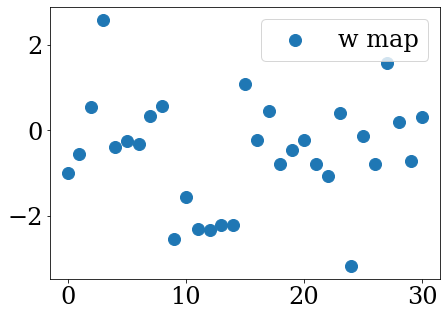

In [194]:
clf.plot_weights()

In [195]:
pred = clf.predict(X_test)

In [196]:
roc_auc_score(Y_test, pred)

0.9004907996882803

In [197]:
pred

array([0.03088445, 0.34816454, 0.74391218, ..., 0.85760344, 0.77495533,
       0.93561041])

In [198]:
len(clf.get_cols())

31

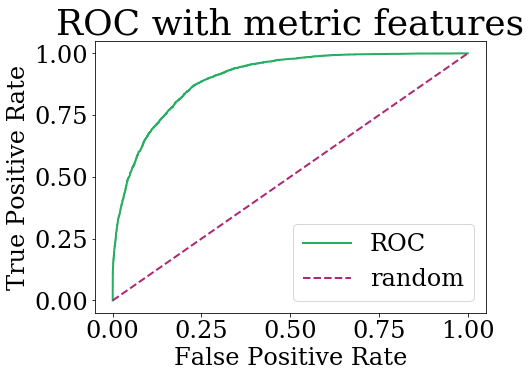

In [199]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, pred, pos_label=None)
plot_roc_cur(fpr, tpr, title='ROC with metric features')

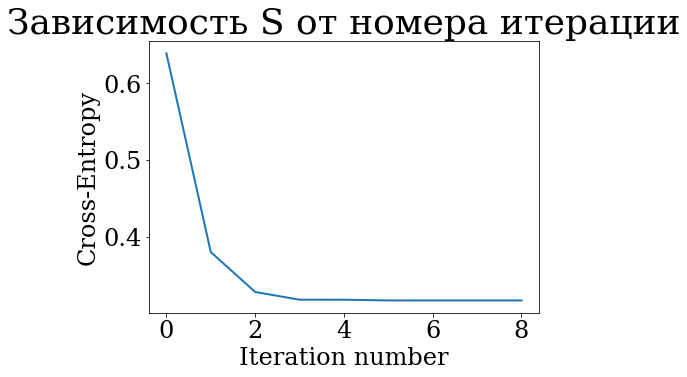

In [200]:
clf.plot_cross_entropy()

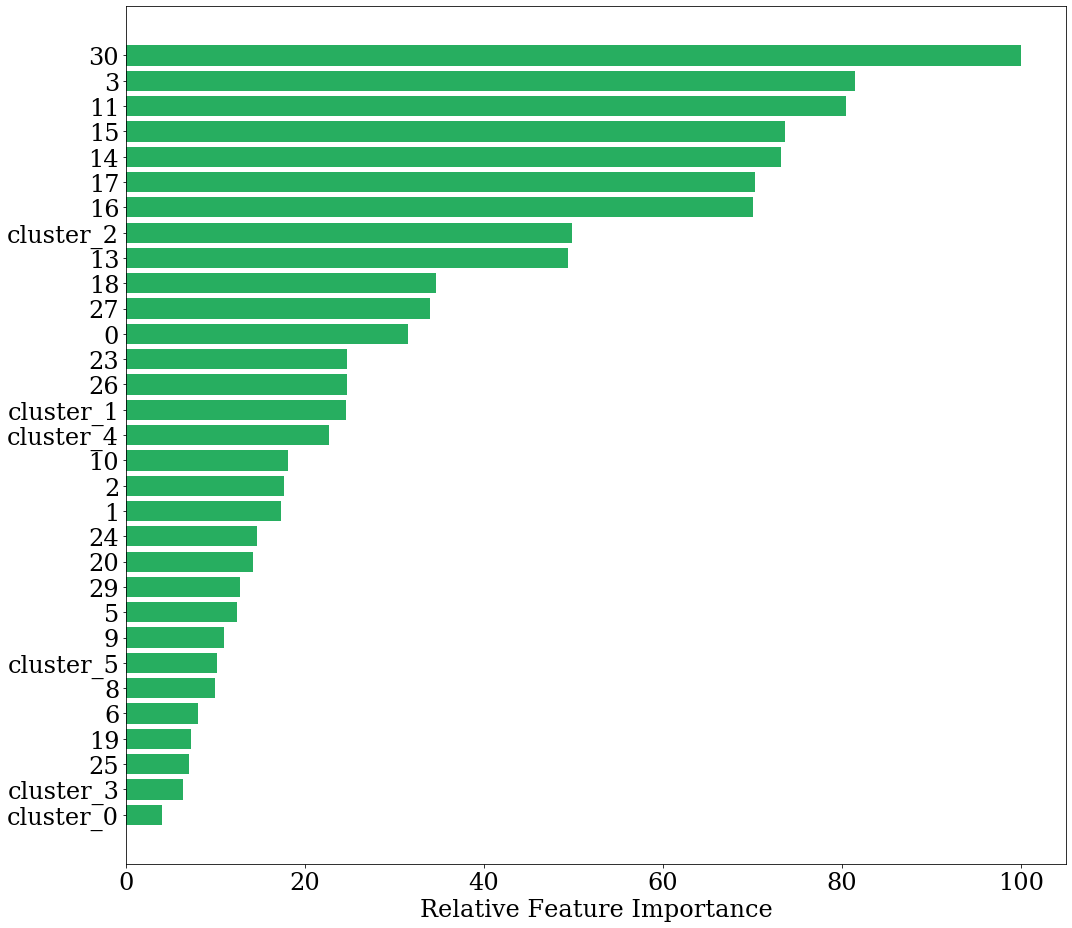

In [201]:
w = clf.get_weights()
cols = clf.get_cols()

plot_feature_importance(w, cols)
plt.savefig('feat_imp.svg')

In [292]:
# cols_name = ['0',
#  'age',
#  'education-num',
#  'capital-gain',
#  'capital-loss',
#  'hours-per-week',
#  'workClass_Self-emp-not-inc',
#  'workClass_Local-gov',
#  'workClass_State-gov',
#  'workClass_Self-emp-inc',
#  'workClass_Federal-gov',
#  'workClass_Without-pay',
#  'workClass_Never-worked',
#  'marital-status_Never-married',
#  'marital-status_Divorced',
#  'marital-status_Separated',
#  'marital-status_Widowed',
#  'marital-status_Married-spouse-absent',
#  'marital-status_Married-AF-spouse',
#  'occupation_Craft-repair',
#  'occupation_Exec-managerial',
#  'occupation_Adm-clerical',
#  'occupation_Sales',
#  'occupation_Other-service',
#  'occupation_Machine-op-inspct',
#  'occupation_Transport-moving',
#  'occupation_Handlers-cleaners',
#  'occupation_Farming-fishing',
#  'occupation_Tech-support',
#  'occupation_Protective-serv',
#  'occupation_Priv-house-serv']

In [354]:
# cols_name2 = ['0',
#              'Возраст',
#               'Образование',
#               'Прирост капитала',
#               'Потеря капитала',
#               'Занятость часов в неделю',
#               'Раб. класс: предприниматель',
#               'Раб. класс: местная власть',
#               'Раб. класс: власть штата',
#               'Раб. класс: наемный работник',
#               'Раб. класс: федеральная власть',
#               'Волонтер',
#               'Безоработный',
#               'Никогда не состоял в браке',
#               'Разведен',
#               'Гражданский брак',
#               'Вдовец',
#               'Брачно-status_Married-супруг-отсутствует',
#               'Брачно-status_Married-AF-супруга',
#               'Вид деятельности: ремонтные работы',
#               'Вид деятельности: управленец',
#               'Вид деятельности: офис',
#               'Вид деятельности: продажи',
#               'Вид деятельности: услуги',
#               'Вид деятельности: инспектор',
#               'Вид деятельности: транспорт',
#               'Вид деятельности: уборщик',
#               'Вид деятельности: рыбалка',
#               'Вид деятельности: тех. поддержка',
#               'Вид деятельности: обеспечение безопасности',
#               'Вид деятельности: охрана частных предприятий']

In [355]:
# dict_cols_name = {str(i): cols_name2[i] for i in range(len(cols_name2))}

In [356]:
# dict_clust_name = {
#  'cluster_2': 'Портрет клиента №2 (расстояние до кластера № 2)',
#  'cluster_0': 'Портрет клиента №0 (расстояние до кластера № 0)',
#  'cluster_1': 'Портрет клиента №1 (расстояние до кластера № 1)',
# }

In [357]:
# for k,v in dict_clust_name.items():
#     dict_cols_name[k] = v

In [359]:
# [x if x not in dict_cols_name else dict_cols_name[x] for x in np.array(cols)[sorted_idx]]

['Портрет клиента №0 (расстояние до кластера № 0)',
 'Вид деятельности: ремонтные работы',
 'Занятость часов в неделю',
 'Раб. класс: предприниматель',
 'Вид деятельности: транспорт',
 'Вид деятельности: обеспечение безопасности',
 'Раб. класс: власть штата',
 'Раб. класс: наемный работник',
 'Вид деятельности: тех. поддержка',
 '0',
 'Вид деятельности: управленец',
 'Образование',
 'Брачно-status_Married-AF-супруга',
 'Вид деятельности: инспектор',
 'Раб. класс: федеральная власть',
 'Портрет клиента №1 (расстояние до кластера № 1)',
 'Портрет клиента №2 (расстояние до кластера № 2)',
 'Вид деятельности: услуги',
 'Вид деятельности: уборщик',
 'Вид деятельности: рыбалка',
 'Вдовец',
 'Разведен',
 'Брачно-status_Married-супруг-отсутствует',
 'Гражданский брак',
 'Волонтер',
 'Никогда не состоял в браке',
 'Прирост капитала',
 'Вид деятельности: охрана частных предприятий']

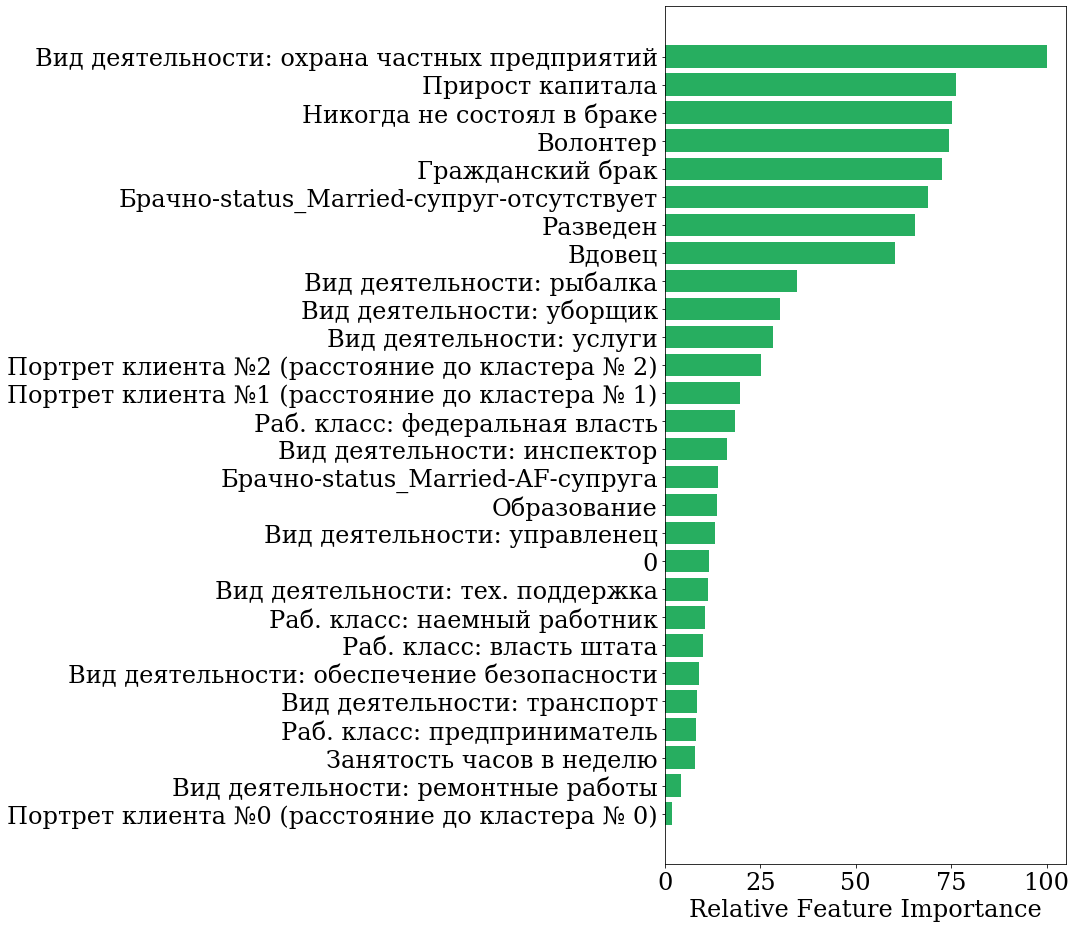

In [360]:
# feature_importance = abs(w)
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
# sorted_idx = np.argsort(feature_importance)
# pos = np.arange(sorted_idx.shape[0]) + .5

# featfig = plt.figure(figsize=(15,13))
# featax = featfig.add_subplot(1, 1, 1)
# featax.barh(pos, feature_importance[sorted_idx], align='center', color='#27AE60')
# featax.set_yticks(pos)
# featax.set_yticklabels([x if x not in dict_cols_name else dict_cols_name[x] for x in np.array(cols)[sorted_idx]])
# featax.set_xlabel('Relative Feature Importance')

# plt.tight_layout()

In [278]:
len(clf.cols)

32

In [369]:
list_w3[0]

array([-0.23628023,  0.18762528,  0.33522469,  1.25422911, -0.1820865 ,
        0.11434146, -0.24333729, -0.06078517, -0.17445916,  0.20723279,
        0.28844422, -0.71215327, -1.77998256, -1.14809855, -1.2203154 ,
       -1.20104831, -1.33110272, -1.21065533, -0.08742351, -0.25208705,
        0.24576271, -0.23142844, -0.05128576, -0.28548419, -0.40629645,
       -0.34472158, -0.36108813, -0.61180293,  0.02704725,  0.11131118,
       -0.43244417,  0.57143907,  0.07681489,  0.14801491, -0.00239574,
       -0.00239574,  0.01212552])

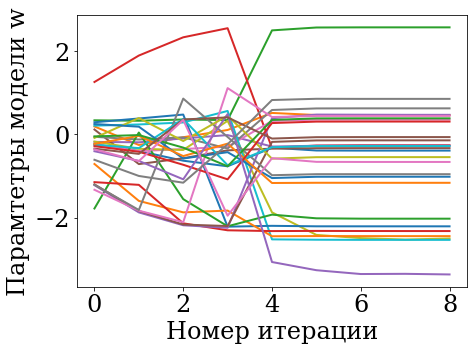

In [387]:
list_w3 = clf.list_w
for i in range(len(list_w3[-1])):
    a = []
    for j in range(len(list_w3)):
        a.append(list_w3[j][i])
    plt.plot(a)
    #plt.show()
    plt.xlabel('Номер итерации')
    plt.ylabel('Парамтетры модели w')
#     plt.title('Параметры модели w')

In [34]:
import numpy as np
from sklearn.model_selection import train_test_split
from logreg import *
T = np.array(T)

costs = []
rocs = []
rocs_val = []
preds_test = []
list_w3_ = []
list_var_w3_ = []

n_bootstraps = 10
rng_seed = 42  # control reproducibility
rng = np.random.RandomState(rng_seed)

i = 0
X_train_, X_val_, T_train_, T_val_ = train_test_split(X, T, test_size=0.33, random_state=42)
for i in range(n_bootstraps):
    
    print('**************')
    print('\n{}-я итерация бутстрэпа'.format(i))
        
    train_index = list(rng.random_integers(0, len(X_train_) - 1, len(X_train_)))
    test_index = list(rng.random_integers(0, len(X_val_) - 1, len(X_val_)))

    X_train, X_val = X_train_[train_index], X_val_[test_index]
    t_train, t_val = T_train_[train_index], T_val_[test_index]
    clf = SuperpositionModel()

    w = np.array([-0.03650337, -0.0107314,  -0.00234493, -0.00433932, -0.03974928, -0.02914917,
     -0.01633966, -0.00345402, -0.03254841, -0.0266781,  -0.04509162, -0.04688906,
     -0.00671441,  0.00415988, -0.02440513, -0.00289427, -0.0157322,  -0.03586732,
     -0.01573701,  0.00779581, -0.02368145,  0.00832795, -0.07535983, -0.00652688,
     -0.02122398, -0.02894507, -0.02633966, -0.04345402, -0.03254841, -0.0666781,
     -0.0033966,  -0.079402,   -0.03254841, -0.04301776, -0.0053454,  -0.0053454])
    clf.set_weights(w)

    clf.fit(X=X_train, T=t_train, feat_threshold=1.0*1e+21, n_clusters=5, algo_clust='km_sklearn')
    costs.append(copy.deepcopy(clf.get_costs()))
    
    pred3 = clf.predict(X_train)
    fpr, tpr, thresholds = metrics.roc_curve(t_train, pred3, pos_label=None)
    rocs.append((fpr, tpr))
    
    pred3_val = clf.predict(X_val)
    fpr_val, tpr_val, thresholds_val = metrics.roc_curve(t_val, pred3_val, pos_label=None)
    rocs_val.append((fpr_val, tpr_val))
    
    pred3_test = clf.predict(X_test)
    preds_test.append(pred3_test)
    
    i = i+1

**************

0-я итерация бутстрэпа
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03254841 -0.04301776 -0.0053454  -0.0053454 ]

0-я итерация

Веса
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03254841 -0.04301776 -0.0053454  -0.0053454 ]

Скоры объектов на 0-й итерации
[0.50886941 0.50327608 0.47813181


Массив метрических признаков на 4-й итерации
[[ 1.81286344 -1.65525314  0.37191226  0.94019929  0.34100338]
 [ 1.01476334 -1.31619649 -0.9201444   0.84119883 -0.0347052 ]
 [ 0.1927506   0.17809685  0.73812981 -1.11302237  0.33674622]
 ...
 [-0.14992245 -0.47558388 -1.44189856  0.06328248 -0.70631278]
 [ 0.69124258 -0.75222458 -0.05307768  0.06888523 -0.28327761]
 [-0.47924505 -0.37935293 -0.61381479 -0.73742566 -1.13873937]]

Скоры объектов на 4-й итерации
[0.09896692 0.00289062 0.18648271 ... 0.01934816 0.02192947 0.47540632]
Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[ 0.24860309  0.7855049   2.57731451  0.69101619 -0.90191902 -0.33163966
 -0.10680126 -0.33286284  0.38740316  0.63443602 -3.27175884  0.3866837
 -3.38146133 -2.32724171 -2.68574089 -2.68850548 -2.6713085  -0.14868144
 -0.42304109  0.34008    -0.35471622 -0.1348476  -1.24609264 -0.732478
 -0.36449772 -1.56002287 -1.57313767  0.10467545  0.18362118 -4.51945399
  0.06572993  1.65232279 -0.80175313


Массив метрических признаков на 9-й итерации
[[ 1.81286344 -1.65525314  0.37191226  0.94019929  0.34100338]
 [ 1.01476334 -1.31619649 -0.9201444   0.84119883 -0.0347052 ]
 [ 0.1927506   0.17809685  0.73812981 -1.11302237  0.33674622]
 ...
 [-0.14992245 -0.47558388 -1.44189856  0.06328248 -0.70631278]
 [ 0.69124258 -0.75222458 -0.05307768  0.06888523 -0.28327761]
 [-0.47924505 -0.37935293 -0.61381479 -0.73742566 -1.13873937]]

Скоры объектов на 9-й итерации
[0.08255658 0.00204209 0.18467462 ... 0.01751592 0.01866962 0.47733493]
Недостаточно итераций для сходимости алгоритма.
**************

1-я итерация бутстрэпа
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0


Массив метрических признаков на 4-й итерации
[[-0.38314168 -0.37083647 -0.75844615 -0.09563709 -1.45801877]
 [ 0.40347118  0.54650929  1.07364999 -0.53873014  0.735702  ]
 [-0.09691673  0.11575169  0.29876854 -1.40079167 -0.01333007]
 ...
 [-1.65913011  0.30311544 -0.77814226 -0.34535626 -1.49925242]
 [ 0.04737478  4.47790394  4.03151204  3.60888327  4.2388208 ]
 [-0.60818096  0.21746276 -0.10750936  0.12969581 -0.7942803 ]]

Скоры объектов на 4-й итерации
[0.24537962 0.1546334  0.50226009 ... 0.41732131 0.04534172 0.0593031 ]
Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-0.33886214  0.69532183  2.57381524 -0.83037929 -0.32968509 -0.1908862
 -0.09534293 -0.21734264  0.32745451  0.74710126 -4.52703017  0.97844923
 -2.90032265 -2.06236978 -2.4632499  -2.46142198 -2.60848237  0.61592928
 -0.32976336  0.46295891 -0.3849994  -0.09161562 -1.01623589 -0.50420449
 -0.3637112  -1.31415454 -1.30658107  0.31645327  0.13962256 -4.06998524
 -0.39289228  0.36892142]
Дисперси


Массив метрических признаков на 9-й итерации
[[-0.38314168 -0.37083647 -0.75844615 -0.09563709 -1.45801877]
 [ 0.40347118  0.54650929  1.07364999 -0.53873014  0.735702  ]
 [-0.09691673  0.11575169  0.29876854 -1.40079167 -0.01333007]
 ...
 [-1.65913011  0.30311544 -0.77814226 -0.34535626 -1.49925242]
 [ 0.04737478  4.47790394  4.03151204  3.60888327  4.2388208 ]
 [-0.60818096  0.21746276 -0.10750936  0.12969581 -0.7942803 ]]

Скоры объектов на 9-й итерации
[0.2430997  0.16516545 0.5117035  ... 0.38812691 0.03935604 0.05800028]
Недостаточно итераций для сходимости алгоритма.
**************

2-я итерация бутстрэпа
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0


Массив метрических признаков на 4-й итерации
[[ 0.85723817 -0.74248459 -0.70419059  0.62666545  0.17526603]
 [-0.87459643  0.08709353 -0.62490653 -0.67116383 -0.59731056]
 [-1.18442166  1.71760235  1.45225574  1.81910616  0.8831229 ]
 ...
 [ 0.1627655  -0.45889466 -0.85683964  0.83036636 -0.20790445]
 [-1.03729199  0.31298152  0.04457297 -0.26453077 -0.57411203]
 [ 2.9306573  -1.1661767   1.98189284  1.63643656  1.36347857]]

Скоры объектов на 4-й итерации
[0.05520861 0.1066711  0.02881094 ... 0.02395491 0.0518469  0.0230077 ]
Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-1.13012215  0.29240973  0.36736467  2.77193255 -2.35721869 -0.07725058
 -0.16778094 -0.05818741  0.35651713  0.53514556 -2.06428819  1.22249266
 -2.3807727  -2.15007175 -2.59721847 -2.29071774 -3.14590852  0.32085271
 -0.13077514  0.60953603 -0.05552213  0.20472433 -0.8291213  -0.31780382
 -0.15931857 -0.70154701 -0.83723437  0.65203465  0.21779696 -2.99742743
 -0.18967507  0.55483007 -0.47785


Массив метрических признаков на 9-й итерации
[[-1.33445829 -0.40476063  0.96972597  0.06276832  0.79394341]
 [-0.08112156 -0.30168074 -0.295662    0.09149924 -0.73739241]
 [-0.01185303  0.87137404  0.56884756 -1.15938309 -0.29462529]
 ...
 [-1.32062891  0.05746219  1.37872572 -0.1900213   0.90600485]
 [ 0.29714514  0.40137406 -0.10216729 -0.15128683 -0.78952124]
 [ 0.05082371  0.61899891  0.302258   -0.69777317 -0.91669251]]

Скоры объектов на 9-й итерации
[0.0803702  0.09683792 0.01380059 ... 0.0163262  0.03689125 0.08054037]
Недостаточно итераций для сходимости алгоритма.
**************

3-я итерация бутстрэпа
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0


Массив метрических признаков на 4-й итерации
[[-0.43151399  0.02993784 -0.19665238 -1.54804075 -0.45308624]
 [ 1.16158523 -1.76233055  0.48515861  0.16782499 -0.41003707]
 [ 0.98617431  0.80082835  0.9785751  -0.63800405  1.43228791]
 ...
 [-1.0703647   0.79578123 -1.64290978 -0.28371132  0.44055709]
 [-0.93794327  0.36819328  0.14711935 -0.19907869 -0.58320169]
 [ 0.26529161 -0.39790205 -0.72558408  1.0231146  -0.1753128 ]]

Скоры объектов на 4-й итерации
[0.68459324 0.00721691 0.05156312 ... 0.8053029  0.04000771 0.0337043 ]
Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-1.07060757  0.17098779  0.22663707  2.56300394 -2.26486428 -0.3553195
 -0.15948365 -0.13461816 -0.12228933  0.44816809  0.69970539 -1.78270951
  0.6547603  -2.3634919  -2.13025055 -2.78060659 -2.27752028 -2.71836955
  1.03289121 -0.24700825  0.36622874 -0.28429914 -0.0147021  -0.95718286
 -0.20299877 -0.24933695 -1.07551614 -1.10614167  0.57609256 -2.68150904
 -0.31724717  0.86659282 -0.572665


Массив метрических признаков на 9-й итерации
[[-0.40323093  0.05079928 -0.16284765 -1.49602048 -0.4018742 ]
 [ 1.04157644 -2.12786341  0.28813066 -0.07159227 -0.74986762]
 [ 0.86273888  0.6938508   0.7948957  -0.95443167  1.24324357]
 ...
 [-1.03605221  0.80289451 -1.59334407 -0.24412718  0.47829337]
 [-0.90446671  0.38877293  0.17745297 -0.16631405 -0.53208806]
 [ 0.28534156 -0.37663252 -0.67490566  1.04656081 -0.13593287]]

Скоры объектов на 9-й итерации
[0.69314951 0.00422557 0.04913657 ... 0.81691151 0.0386485  0.02812094]

Алгоритм сошелся за 10 итераций
**************

4-я итерация бутстрэпа
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03


Массив метрических признаков на 4-й итерации
[[-0.63970973  0.24730102  0.25366113 -1.18126643 -0.50827728]
 [ 0.10917556  1.38014702  1.36746169 -1.32816163  0.2107781 ]
 [ 1.43499149  0.22005036 -1.13333862  1.2659682   0.90636632]
 ...
 [ 0.53968791 -1.56214095 -0.25960676  1.79875165  1.65733031]
 [-2.33044126 -0.42283314  1.11341434 -0.52537925  0.38580844]
 [ 0.31046983 -0.19142878 -1.37336722 -0.02574381 -1.06221467]]

Скоры объектов на 4-й итерации
[0.0123353  0.00441408 0.0554448  ... 0.7674117  0.05349442 0.17061765]
Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-0.99676509  0.39444893  0.43511458  2.85718679 -1.95149075 -0.10055036
  0.65686902  0.94494791 -1.83201188  0.74813233 -2.64696758 -2.07971847
 -2.20333757 -2.41912918 -2.17261293  2.23938858  0.10979662  0.71147601
 -0.10287945  0.29947633 -0.98318956 -0.16255446  0.14463414 -0.65545511
 -0.63695794  0.54690583  0.38630509 -2.40189918 -0.19026174 -0.30402574
 -0.09510637  0.02271345]
Дисперс


Массив метрических признаков на 9-й итерации
[[-0.63970973  0.24730102  0.25366113 -1.18126643 -0.50827728]
 [ 0.10917556  1.38014702  1.36746169 -1.32816163  0.2107781 ]
 [ 1.43499149  0.22005036 -1.13333862  1.2659682   0.90636632]
 ...
 [ 0.53968791 -1.56214095 -0.25960676  1.79875165  1.65733031]
 [-2.33044126 -0.42283314  1.11341434 -0.52537925  0.38580844]
 [ 0.31046983 -0.19142878 -1.37336722 -0.02574381 -1.06221467]]

Скоры объектов на 9-й итерации
[0.01037021 0.00360355 0.04654395 ... 0.77063278 0.04553947 0.16825278]

Алгоритм сошелся за 10 итераций
**************

5-я итерация бутстрэпа
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03


Массив метрических признаков на 4-й итерации
[[ 0.79365086 -0.05899321  1.89409978  0.60366875 -0.04735221]
 [-0.34442825  0.03214682 -0.17022271 -1.77512752 -0.24874347]
 [-0.23589925 -0.81179935 -0.46057523 -0.17264673 -1.27371243]
 ...
 [-0.41702638  0.37639398 -1.47700955  0.76400895  0.32439154]
 [ 0.05081761  1.27846808 -0.3248756   1.65892119  1.43814538]
 [-0.02880152 -0.87873305  0.12737684  0.13915441 -1.43692673]]

Скоры объектов на 4-й итерации
[0.00193371 0.18073975 0.02194909 ... 0.6669966  0.90034648 0.01345243]
Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-0.89702844  0.32366711  0.38728568  2.66390213 -1.38602392 -0.16013164
 -0.23345186 -0.14001878 -0.08521039  0.36622097  0.64749787 -2.75921365
  1.36158042 -2.24566711 -1.9507218  -2.35549543 -2.00141432 -2.67262905
  2.12509885 -0.17713748  0.3088996  -0.27898165 -0.03413015 -0.92220482
 -0.28783292  0.01854237 -0.87777524 -1.15104103  0.31450262  0.80182125
 -2.73042365 -0.26338161  0.63376


Массив метрических признаков на 9-й итерации
[[ 0.79365086 -0.05899321  1.89409978  0.60366875 -0.04735221]
 [-0.34442825  0.03214682 -0.17022271 -1.77512752 -0.24874347]
 [-0.23589925 -0.81179935 -0.46057523 -0.17264673 -1.27371243]
 ...
 [-0.41702638  0.37639398 -1.47700955  0.76400895  0.32439154]
 [ 0.05081761  1.27846808 -0.3248756   1.65892119  1.43814538]
 [-0.02880152 -0.87873305  0.12737684  0.13915441 -1.43692673]]

Скоры объектов на 9-й итерации
[0.00147713 0.16353682 0.01850472 ... 0.6689043  0.90311469 0.01079615]

Алгоритм сошелся за 10 итераций
**************

6-я итерация бутстрэпа
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03


Массив метрических признаков на 4-й итерации
[[ 0.41347855 -0.22510803 -0.59138637  0.56868938 -0.11321129]
 [-0.75245136 -0.18381423 -0.30801334 -0.96913569 -0.72029502]
 [-1.48280299 -0.72120326  0.19892602 -0.43492594 -0.0098496 ]
 ...
 [ 1.42428289  1.93692168  0.51696998 -0.60098687  0.25371241]
 [-0.08137904  0.17041857 -0.70587531 -0.79474827 -0.94724242]
 [ 2.82834595  1.78553769 -0.3631217   1.73210054  1.74168209]]

Скоры объектов на 4-й итерации
[0.0597236  0.04480163 0.05998244 ... 0.00650532 0.03277284 0.22723433]
Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-2.56889514e+02  4.65235029e-01  4.15789426e-01  2.80737016e+00
 -1.18239984e+03 -3.14542437e-02  1.45308997e-01 -3.58288746e-03
  9.86999656e-01  7.11667075e-01  1.10965453e+02 -2.54482220e+02
 -2.34680092e+00 -2.05329727e+00 -2.19671725e+00 -2.35897317e+00
 -2.35010818e+00  1.29224458e+00  9.98676531e-02  6.36164997e-01
 -7.87845633e-02  1.57001006e-01 -1.03870653e+00 -1.56043890e-01
  1.0340

Недостаточно итераций для сходимости алгоритма.

9-я итерация

Веса
[-1.92277308e+03  4.92396635e-01  3.26796095e-01  2.79030775e+00
 -8.87168059e+03 -5.71099329e-02  1.13920889e-01 -3.54121040e-02
  9.59427280e-01  6.87451091e-01 -1.55903590e+02 -1.52139331e+03
 -2.37818526e+00 -2.07430880e+00 -2.24749490e+00 -2.42760972e+00
 -2.43831991e+00  1.07877423e+00  5.86049187e-02  5.89100415e-01
 -1.18745241e-01  1.10879768e-01 -1.10983513e+00 -2.13442657e-01
  4.85218411e-02 -8.30555339e-01 -4.79670698e-01  3.87183803e-01
  5.57830545e-01 -4.37612816e+00 -1.64017803e-01 -4.79095604e-01]
Дисперсии весов
[ 2.58235534e+11  5.54385063e+18 -5.97713067e+17  2.03617473e+16
  9.49971537e+10 -9.58828914e+20 -2.81719257e+20 -6.94361096e+20
 -1.46510962e+18 -5.92810396e+16  5.31630590e+13  7.49708929e+11
 -4.12116914e+17  5.08757693e+17 -2.06375811e+17 -5.47498941e+17
 -4.43934288e+17  9.36070853e+16  3.72486339e+20  1.05432061e+17
 -1.48253649e+19  2.79021959e+19 -4.38725947e+17 -1.32830218e+18
 -3.0


Массив метрических признаков на 3-й итерации
[[-0.66217965  0.73558974  0.98683238 -1.41949853 -0.18080503]
 [-0.08619864 -0.02697653 -0.88675731 -0.55009631 -1.904921  ]
 [ 0.64038553  0.03743886 -1.04046705  0.35473374 -0.45872518]
 ...
 [-0.80605105 -1.17325118 -1.75480679 -0.52292309 -2.33565095]
 [ 1.68063724  2.66792992  1.85712724 -0.59130429  1.06472572]
 [ 1.2707792  -0.05046545 -1.769717    1.12458083  0.43123129]]

Скоры объектов на 3-й итерации
[0.02105595 0.26396448 0.21481916 ... 0.43911524 0.00209096 0.33249904]
Недостаточно итераций для сходимости алгоритма.

4-я итерация

Веса
[-0.65303406  0.62897015  0.37469457  2.66246313 -0.29828024 -0.14596923
  0.15041335  0.00913373  0.59739986  0.7508984  -0.93518533  0.25304546
 -2.41877883 -1.89286934 -2.45661706 -2.26164276 -2.49442589  2.53011856
 -0.01951473  0.7047431  -0.11557343  0.40163677 -0.99528012 -0.15264702
 -0.08838086 -0.76591742 -0.76392814  0.43202071  0.68326036 -1.61814177
 -0.1465895  -0.40718626  0.09481

Недостаточно итераций для сходимости алгоритма.

8-я итерация

Веса
[-0.70087998  0.56884065  0.57143961  2.71285625 -0.30270535 -0.13075977
  0.18941228  0.61642111  0.78665425 -1.76073975 -2.50193627 -1.91963579
 -2.50706644 -2.36799364 -2.57793781  2.52149087 -0.03251145  0.73373609
 -0.12992633  0.42137151 -1.09322866 -0.14830838 -0.08800888 -0.78131022
 -0.76349195  0.44819581  0.6474797  -2.97301523 -0.09203826 -0.33129151
 -0.12022611]
Дисперсии весов
[-5.61841030e+16  7.96177586e+17 -1.52453704e+18 -3.18771214e+15
 -4.49228565e+17  1.81666778e+18  1.04165999e+18 -8.69010562e+17
  1.71011665e+17  1.65516036e+16 -1.86528270e+16 -2.38643106e+15
 -1.65029263e+16  8.83030911e+14  1.70537774e+16  2.19812429e+16
  4.15902457e+19 -6.19328551e+17  1.30578600e+19 -3.07442663e+17
  1.69881108e+16 -1.73032072e+18  1.86318437e+18  1.09735960e+16
  7.39068143e+17  2.04881936e+17  4.53591663e+17 -7.57907051e+16
 -3.42539573e+18 -2.57297940e+17  1.14623663e+18]

Список выбранных на текущей ите


Массив метрических признаков на 2-й итерации
[[ 0.20206692 -0.50916256  0.86819115 -0.07864065 -0.81073477]
 [ 0.17916656 -0.90060411  0.14573284  0.7400161  -1.05358796]
 [-1.74492491  1.45635369 -0.59506132  0.66700979  0.85047587]
 ...
 [-0.32288757  0.09260884 -0.24052919 -1.85751426 -0.2668545 ]
 [ 0.29065629  0.9772465   0.3281322  -0.78115539  1.13766875]
 [ 0.20069985  0.8471372   0.41816003 -1.39020835  0.8727785 ]]

Скоры объектов на 2-й итерации
[0.04457667 0.06146455 0.71488315 ... 0.34006488 0.40088494 0.36916269]
Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-1.01651351  0.21417386  0.39562345  2.39884611 -3.4055584  -0.23953706
 -0.27727168 -0.0667926  -0.21097209  0.38632836  0.58931704 -0.17907064
 -1.51325147 -2.01867273 -2.00815794 -1.99682156 -2.30139011 -2.23694122
  0.52530525 -0.39176537  0.44345891 -0.28314492 -0.12720309 -0.66484988
 -0.51047423 -0.21533612 -0.8745743  -1.21786988 -0.00625409 -0.01146648
 -1.12146236 -0.2575278   0.45942

Недостаточно итераций для сходимости алгоритма.

7-я итерация

Веса
[ 1.98442919e+01  2.97760322e-01  2.74205867e-01  2.76562787e+00
  9.51209423e+01 -1.82588004e-01 -1.46234112e-01  3.70061378e-02
 -6.96596779e-02  5.20770389e-01  7.57640649e-01 -2.46845131e+09
  3.71528397e+11 -2.48443834e+00 -2.08512207e+00 -1.99127644e+00
 -2.23618876e+00 -2.02670264e+00  2.01565302e+00 -5.37341339e-02
  6.78534761e-01  3.28970934e-02  8.54680654e-02 -7.29822092e-01
 -1.15257301e-01  1.96319771e-01 -7.09981577e-01 -1.06234289e+00
  3.88848875e-01  3.48903005e-01 -1.66113041e+10 -2.03532237e-01
  7.05884463e-01 -5.65565835e-01]
Дисперсии весов
[ 1.24542545e+15 -5.90313437e+18 -1.81107659e+19 -2.26947855e+17
  5.65302524e+14 -1.11603703e+19  1.20088347e+20 -2.27496038e+21
  2.40161430e+19 -3.29233470e+18 -1.16020205e+18  2.04338921e-01
  2.77950058e-05  5.60473485e+17  6.26143011e+17  8.90025039e+16
  6.22760550e+16  6.54200306e+16  1.78000472e+17  1.69231953e+21
 -3.27515419e+17  7.74943263e+20  1.0


Массив метрических признаков на 1-й итерации
[[-0.18877028 -0.30797566 -0.32699627 -0.26466809 -0.61867935]
 [ 0.18136194  0.95314182 -0.98491755  0.24743102  1.30185401]
 [-0.91331141  0.3465345  -0.65310639 -1.41205696 -0.24088072]
 ...
 [-1.46849093  2.01283318  1.05406154  0.4186539   1.312026  ]
 [-0.1083841  -0.72914375  0.038694   -0.02174179 -1.31688481]
 [ 0.65269937 -1.28684069  0.17110864 -0.35972461 -0.83689932]]

Скоры объектов на 1-й итерации
[0.39021284 0.8624322  0.31339232 ... 0.1180592  0.25974034 0.19442446]
Недостаточно итераций для сходимости алгоритма.

2-я итерация

Веса
[-0.68147111  0.02789852  0.43723795  1.95297071 -2.65666552 -0.43818255
 -0.28436239 -0.10410355  0.38815769  0.25035807 -2.93206915  0.35657083
 -1.66446982 -1.89291317 -1.96223322 -1.92863085 -2.15166043  0.10363566
 -0.38399645  0.26144814 -0.30703599 -0.121329   -0.43212281 -0.66196063
 -0.40661866 -0.78107104 -1.1234284   0.05684547  0.12811964 -0.84522131
 -0.24319027  0.46926567  0.04891

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-3.56958890e-01  7.31568988e-01 -7.57514164e-02  2.40615661e+00
 -2.86300733e-02  1.10413675e-01  6.29414473e-01  5.36888591e-01
  1.78623087e+00 -4.61954809e+01 -2.41025585e+00 -1.78293255e+00
 -2.28767735e+00 -2.10349126e+00 -2.38417787e+00  1.26661092e+00
  5.02612217e-02  4.12721471e-01 -1.71078205e-01  7.15628554e-02
 -9.58214874e-01 -3.29437979e-01  5.43908119e-02 -9.23576787e-01
 -1.02385591e+00  3.18965309e-01  5.08354971e-01 -2.02678491e+01
 -2.64343936e-01 -7.20019163e-01  3.65248613e-01]
Дисперсии весов
[ 9.01112044e+18 -2.13344911e+17  3.55367135e+19  1.84168997e+16
  3.39369168e+20 -3.66768043e+19 -1.09905451e+18 -1.56303151e+17
  1.00267763e+16  2.11717911e+14  1.47222887e+16  5.92988238e+14
 -7.61473004e+15  2.73284368e+16  1.33524435e+16 -9.15696081e+16
  4.69406639e+19  1.48589447e+17  2.81119717e+19 -4.54400971e+18
 -2.33373187e+16  3.37314440e+17  3.17837413e+19  2.50805662e+16
 -4.53567584e+17 -2.9

In [35]:
costs = np.array(costs)

In [52]:
costs

array([[0.68399637, 0.46624663, 0.34198635, 0.32382754, 0.32069503,
        0.32063188, 0.32053703, 0.32065755, 0.32053067, 0.34406175],
       [0.68459829, 0.44767123, 0.35160642, 0.33397055, 0.33126936,
        0.33111206, 0.33116214, 0.33728298, 0.32053067, 0.34406175],
       [0.68467493, 0.45332095, 0.34614278, 0.32398616, 0.31955155,
        0.38264754, 0.32928828, 0.3254433 , 0.32536645, 0.3253636 ],
       [0.68482945, 0.4415144 , 0.34231046, 0.31972461, 0.31483654,
        0.31449609, 0.31448447, 0.31458747, 0.31453498, 0.31453472],
       [0.68453681, 0.43977316, 0.37922238, 0.33179907, 0.3275697 ,
        0.32733688, 0.32732375, 0.32732022, 0.32731865, 0.32731832],
       [0.6846642 , 0.47788965, 0.3525306 , 0.3291069 , 0.32411865,
        0.32377083, 0.32375802, 0.32375576, 0.32375473, 0.32375435],
       [0.68470179, 0.40983185, 0.36362498, 0.32664526, 0.32369221,
        0.32350139, 0.32364566, 0.3236109 , 0.32350384, 0.32349412]])

In [47]:
#costs = np.delete(costs, -2, axis=0)

In [53]:
#costs[1][-2] = costs[0][-2]

In [54]:
mean_costs = costs.mean(axis=0)
mean_costs.shape

(10,)

In [55]:
mean_costs

array([0.68457169, 0.44803541, 0.35391771, 0.32700859, 0.32310472,
       0.3319281 , 0.32431419, 0.32466545, 0.32222   , 0.32894123])

In [56]:
error = costs.std(axis=0)

In [74]:
mean_costs[5] = mean_costs[6]

In [75]:
#mean_costs[5]=mean_costs[4]

Text(0, 0.5, 'Кросс-энтропия')

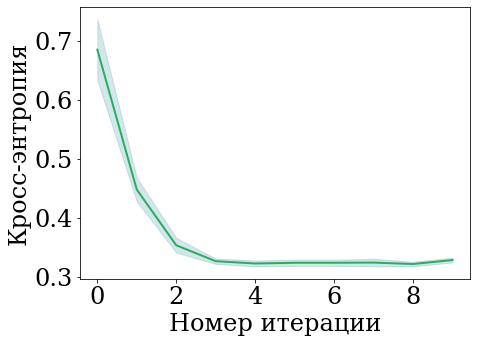

In [76]:
plt.plot(np.arange(len(mean_costs)),mean_costs, lw=2, color='#27AE60', alpha=1)
plt.fill_between(np.arange(len(mean_costs)), mean_costs-error, mean_costs+error, color='#539caf', alpha=0.25)
plt.xlabel('Номер итерации')
plt.ylabel('Кросс-энтропия')
# plt.title('Зависимость S от номера итерации')

In [218]:
costs_exp = -1*np.exp(costs)
mean_costs = costs_exp[:-1, :].mean(axis=0)
error = costs_exp[:-1, :].std(axis=0)

Text(0.5, 1.0, 'Зависимость evp(-S) от номера итерации')

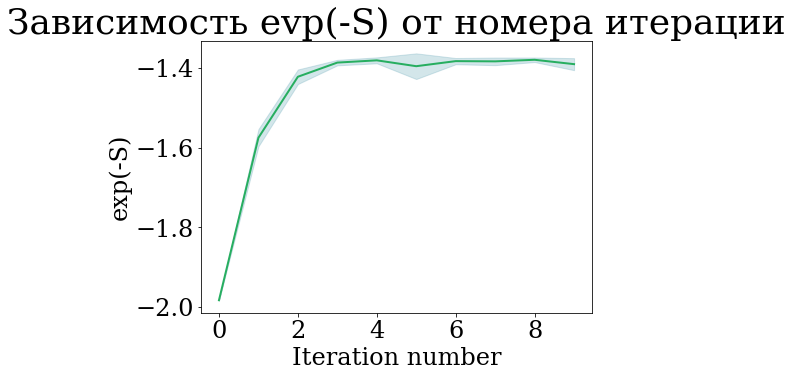

In [219]:
plt.plot(np.arange(len(mean_costs)),mean_costs, lw=2, color='#27AE60', alpha=1)
plt.fill_between(np.arange(len(mean_costs)), mean_costs-error, mean_costs+error, color='#539caf', alpha=0.25)
plt.xlabel('Iteration number')
plt.ylabel('exp(-S)')
plt.title('Зависимость evp(-S) от номера итерации')

In [170]:
# rocs[1] = rocs[0]
# rocs_val[1] = rocs_val[0]

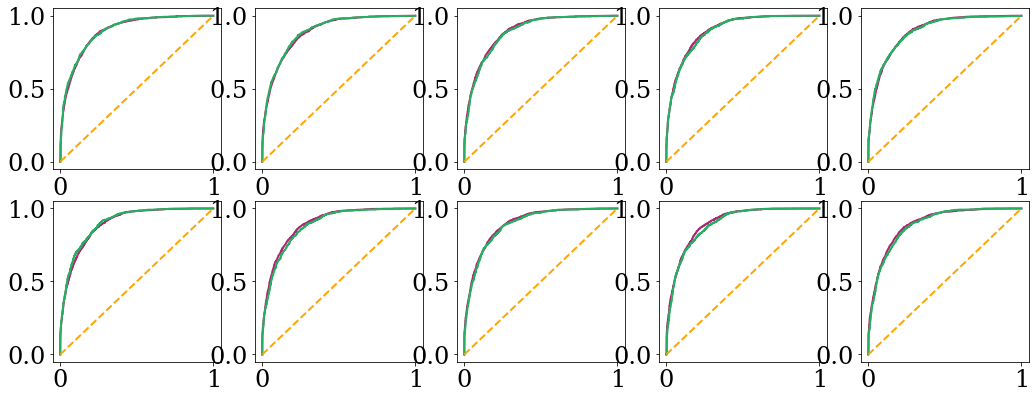

In [243]:
fig, axes = plt.subplots(2, 5, figsize=(17.5, 6.5))
for i, (a, b) in enumerate(zip(rocs, rocs_val)):
    idx = i%5
    
    fpr, tpr = a
    fpr_v, tpr_val = b
    
    axes[i//5, idx].plot(fpr, tpr, color='#AE2775', label='ROC')
    axes[i//5, idx].plot(fpr_v, tpr_val, color='#27AE60', label='ROC')
    axes[i//5, idx].plot([0, 1], [0, 1], color='orange', linestyle='--', label='Random decision line')
#     axes[idx, i//5].xlabel('False Positive Rate')
#     axes[idx, i//5].ylabel('True Positive Rate')
#     axes[i//5, idx].set_title('title')
#     axes[idx, i//5].legend()
    
#     plot_roc_cur(fpr, tpr, title='ROC-кривая на тестовой выборке')
#     plt.show()

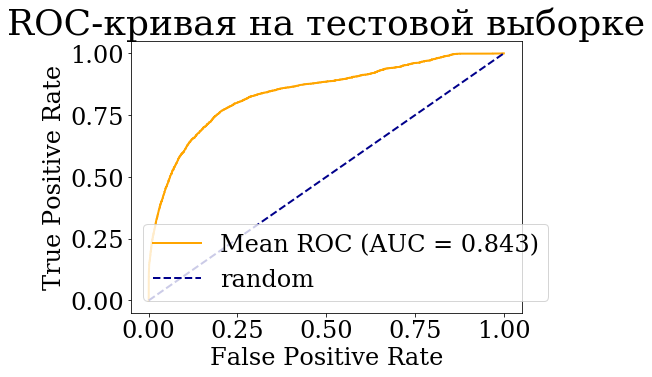

In [244]:
t_test = Y_test
t_test = t_test

preds_test = np.array(preds_test)
roc = roc_auc_score(t_test, preds_test.mean(axis=0))

fpr_test, tpr_test, thresholds_test = metrics.roc_curve(t_test, preds_test.mean(axis=0), pos_label=None)
plt.plot(fpr_test, tpr_test, color='orange', label='Mean ROC (AUC = %s)' % round(roc, 3))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая на тестовой выборке')
plt.legend()

IndexError: index 29 is out of bounds for axis 0 with size 29

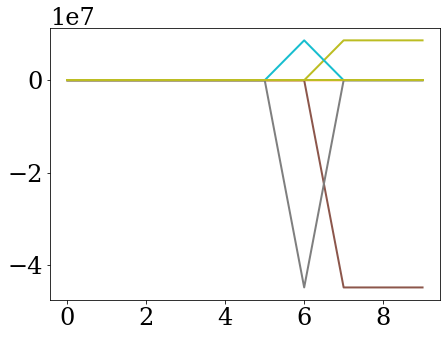

In [173]:
list_w3 = clf.list_w
for i in range(len(list_w3[0])):
    a = []
    for j in range(len(list_w3)):
        a.append(list_w3[j][i])
    plt.plot(a)
    #plt.show()

In [174]:
def var_of_w(l, i):
    res = []
    for item in l:
        if len(item) > i:
            res.append(item[i])
    return res

In [175]:
list_w3_ = list_w3_[-1]

IndexError: list index out of range

IndexError: list index out of range

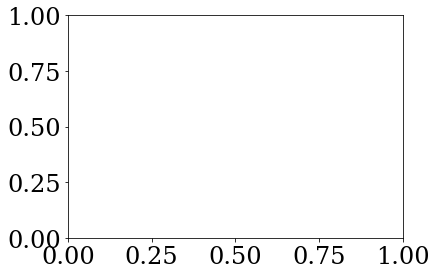

In [176]:
plt.figure(figsize=(6,9))
plt.subplot(211)
for i in range(len(list_w3_[0])):
    if len(var_of_w(list_w3_, i))<len(var_of_w(list_w3_, 0)):
        plt.plot(var_of_w(list_w3_, i), color='r')
plt.xlabel('Номер итерации')
plt.ylabel('Парамтетры модели w')
plt.title('Параметры модели w, соответствующие неинформативным признакам')
plt.subplot(212)
for i in range(len(list_w3_[0])):
    if len(var_of_w(list_w3_, i))>=len(var_of_w(list_w3_, 0)):
        plt.plot(var_of_w(list_w3_, i), color='g')
plt.xlabel('Номер итерации')
plt.ylabel('Парамтетры модели w')
plt.title('Параметры модели w, соответствующие информативным признакам')
plt.savefig('5.png')

In [177]:
list_var_w3_ = list_var_w3_[-1]

IndexError: list index out of range

IndexError: list index out of range

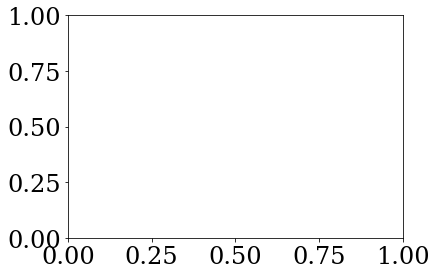

In [178]:
plt.figure(figsize=(6,9))
plt.subplot(211)
for i in range(len(list_var_w3_[0])):
    if len(var_of_w(list_var_w3_, i))<len(var_of_w(list_var_w3_, 0)):
        plt.plot(var_of_w(list_var_w3_, i), color='r')
        plt.ylim(0,15)
plt.xlabel('Номер итерации')
plt.ylabel('Элементы матрицы A')
plt.title('Элементы матрицы A, соответствующие шумовым параметрам модели w')
plt.subplot(212)
for i in range(len(list_var_w3_[0])):
    if len(var_of_w(list_var_w3_, i))>=len(var_of_w(list_var_w3_, 0)):
        plt.plot(var_of_w(list_var_w3_, i), color='g')
        plt.ylim(0,15)
plt.xlabel('Номер итерации')
plt.ylabel('Элементы матрицы A')
plt.title('Элементы матрицы A, соответствующие шумовым параметрам модели w')
plt.savefig('6.png')

In [374]:
costs_all = []
rocs_all = []
for n_clusters in np.arange(0,10):
    costs = []
    rocs_val = []
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(X):
    #     print('ИТЕРАЦИЯ', i)
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_val = X[train_index], X[test_index]
        t_train, t_val = T[train_index], T[test_index]
        
        clf = SuperpositionModel()

        w = np.array([-0.03650337, -0.0107314,  -0.00234493, -0.00433932, -0.03974928, -0.02914917,
         -0.01633966, -0.00345402, -0.03254841, -0.0266781,  -0.04509162, -0.04688906,
         -0.00671441,  0.00415988, -0.02440513, -0.00289427, -0.0157322,  -0.03586732,
         -0.01573701,  0.00779581, -0.02368145,  0.00832795, -0.07535983, -0.00652688,
         -0.02122398, -0.02894507, -0.02633966, -0.04345402, -0.03254841, -0.0666781,
         -0.0033966,  -0.079402,   -0.03254841, -0.04301776, -0.0053454,  -0.0053454,
        -0.0013966,  0.089402,   -0.02354841, 0.02301776, -0.00893454,  -0.0013454])[:31+n_clusters]
        clf.set_weights(w)
        
        clf.fit(X_train, t_train, feat_threshold=10*1e+19, n_clusters=n_clusters, iterations=9, algo_clust='km_simple')
        
#         w3, list_w3, list_var_w3, list_var_obj3, costs3, cols3, metric_mask3, cluster_centers3 = fit_with_obj_feat_selection_MF(X=X_train, T=t_train, iterations=10, 
#     #                                                                             obj_threshold=0.2499,
#                                                                                         obj_threshold=100000000.0, 
#                                                                                         feat_threshold=1.0*1e+20, 
#     #                                                                                     feat_threshold=9.5*1e+00,        
#                                                                                         n_clusters=n_clusters)

        pred3 = clf.predict(X_val)
        roc = roc_auc_score(t_val, pred3)
        rocs_val.append(copy.deepcopy(roc))
        
        costs.append(copy.deepcopy(clf.get_costs()[-1]))
        
    costs_all.append(costs)
    rocs_all.append(rocs_val)

TRAIN: [ 2844  2845  2846 ... 28435 28436 28437] TEST: [   0    1    2 ... 2841 2842 2843]
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966 ]

0-я итерация

Веса
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966 ]

Скоры объектов на 0-й итерации
[0.48960584 0.50304991 0.47549136 ... 0.48802181 0.51187494 0.47627173]
Недостаточно итераций для схо

Недостаточно итераций для сходимости алгоритма.

7-я итерация

Веса
[-0.36701203  0.49763752  0.82099895  2.60735587 -0.66317636  0.3548334
 -0.48242261 -0.11786346 -0.32418854  0.12557964  0.49656987 -2.92186781
 -1.9534582  -2.72005187 -2.20965897 -2.50035731 -2.58270591 -2.4293543
  1.29037345 -0.22314004  0.41520806 -0.27130426 -0.07252397 -1.21498069
 -0.63708345 -0.42733318 -1.03153644 -1.35299858  0.31790465  0.26584877
 -3.57374894]
Дисперсии весов
[-3.27295845e+17  8.39264844e+16  7.95451009e+16 -9.66093051e+15
  1.55552537e+17 -4.81949226e+14  5.03721996e+15 -2.54794596e+18
 -4.68860819e+17  6.04472582e+17  1.15466275e+17 -6.94361055e+13
  3.08741868e+13 -3.87636417e+15 -6.46838389e+15  9.05504791e+15
  2.05194586e+15  1.21909807e+15  8.23851307e+15 -2.80644426e+17
  2.81027730e+16  1.82788446e+17 -3.71982483e+18  1.66749559e+16
  1.00373870e+16  1.53105826e+17 -1.72599763e+16 -4.26604013e+15
 -3.92479799e+16 -3.94219480e+17  4.19512218e+15]

Список выбранных на текущей итера

Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-0.26506492  0.49660949  0.81951712  2.60307535  0.3839478  -0.49950377
 -0.29826795  0.52320186 -2.67807429 -1.00335152 -2.70473402 -2.2505308
 -2.45803893 -2.38059079 -2.44178257  0.98723163 -0.20661135  0.47398848
 -0.23357461 -1.07561611 -0.56526843 -0.35796035 -1.09384975 -1.28914486
  0.24905848  0.27043775 -3.26765489]
Дисперсии весов
[ 5.33391970e+18  7.95186295e+16  2.06700511e+17 -2.32962858e+15
  4.70618174e+16 -1.11050056e+18  3.92447487e+17 -1.83741574e+16
 -2.53002708e+16 -6.27815068e+16 -3.57058952e+15 -2.20850060e+16
 -5.28586414e+15  2.10684745e+16  4.96567539e+16  2.58350622e+17
 -3.00699589e+17 -3.52871094e+17 -2.79640261e+17  9.35185562e+15
 -3.02188415e+16  2.29461928e+17 -1.58106807e+15 -1.14046462e+16
 -4.96410012e+17  1.86129855e+18  1.19444834e+16]

Список выбранных на текущей итерации признаков
['0', '1', '2', '3', '5', '6', '8', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-0.2106343   0.46243175  0.7427667   2.45074587 -0.0548403   0.33020455
 -0.49672277 -0.12232441 -0.31367036  0.15855816  0.53379343 -1.34058664
  0.69583202 -2.39589118 -2.12933765 -2.3082928  -2.37291915 -2.1703678
  0.95505798 -0.25740197  0.40539354 -0.30475664 -0.93769058 -0.6339231
 -0.447718   -0.92246779 -1.27562669  0.23999273 -1.58828131]
Дисперсии весов
[ 4.86267445e+18  1.84835533e+17  2.51415207e+17 -1.01898121e+16
 -2.85428329e+17 -8.95370012e+16 -7.28589252e+16  1.26720528e+19
  4.10938438e+17  3.56332535e+18 -8.90662118e+17  2.29734734e+16
 -2.02517296e+17  6.79609658e+15  9.96861219e+14 -1.70276852e+16
 -4.49013626e+16  2.24642305e+16  6.90045234e+16 -5.10082248e+16
  9.81828515e+16  6.36121566e+17  7.47544152e+14  1.14400931e+18
 -3.72196275e+17  1.40205813e+16  8.07396912e+16  1.54034683e+18
  3.23822068e+16]

Список выбранных на текущей итерации признаков
['0', '1', '2', '3', '4', '5', '6', '7', '8

Недостаточно итераций для сходимости алгоритма.

1-я итерация

Веса
[-0.22734914  0.18659276  0.34612867  1.25707517  0.05092962  0.11628315
 -0.2511687  -0.06488857 -0.1302381   0.22815587  0.30421638  0.6090815
 -0.41959602 -1.14481244 -1.22070344 -1.20076962 -1.31361216 -1.19741213
  0.20948842 -0.21689701  0.28805688 -0.20333689  0.01007249 -0.23576665
 -0.36033739 -0.30234213 -0.30595592 -0.58390208  0.0507765   0.20338801
 -0.32577439]
Дисперсии весов
[ 6.57178225e+18 -7.53317406e+18  2.11939201e+18 -4.75438299e+16
  2.69559195e+18  1.34008686e+19  3.36077512e+18  3.56249620e+19
 -2.95185210e+18 -2.16575616e+18  2.27411802e+17 -9.26174205e+17
  4.97363206e+17 -4.25168668e+16  1.14717606e+17  2.55705771e+17
 -7.72671608e+16  1.76262279e+16 -6.23078106e+17 -2.79374746e+18
 -4.17163562e+17  4.70834869e+17 -4.95470916e+20  5.04758720e+17
  1.04245779e+18  8.03451759e+17  1.54785122e+17 -7.80879320e+17
  1.44449378e+19 -7.40993618e+18  1.31799736e+17]

Список выбранных на текущей итер

Недостаточно итераций для сходимости алгоритма.

8-я итерация

Веса
[-0.23626881  0.50008868  0.82214077  2.62844084  0.36835016 -0.5175735
 -0.12782531 -0.2287809   0.15553823  0.55344845 -2.92323645 -1.8388173
 -2.71434893 -2.26436782 -2.51628627 -2.50400921 -2.50639468  0.74380003
 -0.22953699  0.46553184 -0.30284084 -1.120102   -0.61081331 -0.41642187
 -1.02314578 -1.40157191  0.27079266  0.30912323 -3.62229389]
Дисперсии весов
[ 9.54669668e+17 -6.01089664e+16 -2.30347830e+15  5.43219610e+16
  2.26229713e+17  1.53033718e+17  1.29454537e+18 -9.59465884e+17
 -1.15956805e+18 -7.31510680e+16  5.85056280e+14 -5.78674067e+15
 -3.52945163e+15 -1.43963373e+16  1.59648920e+15  3.24788173e+15
 -1.73553999e+15 -1.48684673e+15 -1.23834577e+17  1.72744042e+17
 -1.68855523e+17  5.13243417e+15 -3.58780512e+16 -5.05978550e+17
  1.45476184e+16 -5.45753920e+15  9.93330599e+16  6.32830922e+17
 -1.83018038e+15]

Список выбранных на текущей итерации признаков
['0', '1', '2', '3', '5', '6', '7', '8', '9

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-0.2565958   0.4877988   0.80735506  2.60827482  0.35706112 -0.49913382
 -0.30519779  0.16243147  0.58655372 -2.79977348 -1.66890118 -2.74559481
 -2.24619213 -2.48082736 -2.40716281 -2.43798113  0.62992744 -0.19893799
  0.46541244 -0.26145204 -1.08718738 -0.59482613 -0.36661267 -1.01065835
 -1.26184991  0.37098522  0.22692452 -3.4651549 ]
Дисперсии весов
[ 1.58248302e+18 -4.47591027e+16 -2.11470830e+17  1.46805566e+16
  4.13401381e+17 -1.65761094e+17 -7.72252496e+16  7.42241410e+17
  3.64406850e+17 -1.52419601e+15  2.68919175e+16  5.19220292e+15
 -4.39281141e+15  1.54553110e+15  8.93470735e+15  1.46014277e+16
  1.42095012e+17  6.50682042e+17 -2.25183605e+17 -2.91989094e+16
  6.57693556e+16  2.78700620e+17 -6.33980048e+16  1.17661737e+16
  7.20731974e+15  6.82412991e+16  4.08832059e+17 -3.04041814e+15]

Список выбранных на текущей итерации признаков
['0', '1', '2', '3', '5', '6', '8', '9', '10', '11', '12', '13', '14',

Недостаточно итераций для сходимости алгоритма.

4-я итерация

Веса
[-0.22491586  0.49802624  0.80040148  2.55373682  0.09309492  0.36988654
 -0.4867937  -0.08336987 -0.21702152  0.12427262  0.54106206 -2.11946085
 -0.19671676 -2.65617506 -2.21405909 -2.43137065 -2.41314679 -2.39078778
 -0.22764747  0.45128489 -0.31121224 -1.13005317 -0.59037259 -0.43111694
 -0.94929402 -1.35023057  0.31016332  0.27942556 -2.44722952]
Дисперсии весов
[-8.78915279e+18  1.10121124e+18  1.37297890e+16 -2.47560797e+16
 -4.22784230e+19  3.30158911e+17  1.02961903e+18  6.80233936e+19
  1.25168638e+18  5.44763013e+17 -1.26052649e+17 -8.51564388e+16
  2.99730884e+18 -9.23115655e+16 -2.15825202e+17 -6.94519157e+15
 -1.97008761e+16 -2.76172259e+16  2.95586671e+18 -3.07728401e+17
 -4.31894255e+17  2.21541849e+17 -1.51390586e+17 -8.80321638e+17
 -1.39642668e+17 -7.85377500e+16  2.39661604e+18 -1.13120401e+18
  8.81202209e+16]

Список выбранных на текущей итерации признаков
['0', '1', '2', '3', '4', '5', '6', '7', 

Недостаточно итераций для сходимости алгоритма.

2-я итерация

Веса
[-0.2716525   0.34666933  0.59010023  1.96989748 -0.09346893  0.228933
 -0.3621191  -0.08082447 -0.25763177  0.2169355   0.42102717 -0.31102661
  1.15483598 -1.85411271 -1.81296073 -1.85272812 -2.00206001 -1.82327335
  0.68455445 -0.21836997  0.38430118 -0.24955814 -0.5303313  -0.50249916
 -0.38363472 -0.61348868 -1.03112239  0.22241418  0.22746512 -0.82187519]
Дисперсии весов
[-9.70998812e+17  1.34660711e+18 -1.20845289e+17 -3.35252162e+16
 -1.40643683e+18  2.52818396e+18  1.25428953e+17  1.47734376e+19
  5.72572501e+17 -3.86181628e+18  1.79494639e+18 -2.92783520e+17
  3.17997317e+16 -5.39342143e+16 -7.44903799e+16 -9.04754318e+16
  8.98162202e+15  3.00261573e+16  1.75060712e+17  8.90278358e+17
  1.40423959e+17 -4.42230139e+17  3.98736794e+17 -9.80679109e+16
  1.95057781e+18 -2.24167125e+17 -6.30900795e+15 -1.28031367e+17
  6.93313295e+17 -1.15655923e+17]

Список выбранных на текущей итерации признаков
['0', '1', '2',


Алгоритм сошелся за 9 итераций
TRAIN: [    0     1     2 ... 28435 28436 28437] TEST: [19908 19909 19910 ... 22749 22750 22751]
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966 ]

0-я итерация

Веса
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966 ]

Скоры объектов на 0-й итерации
[0.48736435 0.49646267 0.48112708 ... 0.48802181 0.51187494 0.4

Недостаточно итераций для сходимости алгоритма.

7-я итерация

Веса
[-0.25118458  0.49685531  0.79956306  2.59262106 -0.13304909  0.35775451
 -0.47241469 -0.09203722 -0.34592853  0.20530037  0.55024969 -2.63155619
 -1.83663071 -2.69072705 -2.2554628  -2.43125835 -2.44570215 -2.31479488
  0.93566943 -0.26241579  0.43927453 -0.29642176 -0.11240288 -1.1219263
 -0.6488698  -0.42901532 -1.05116102 -1.38409367  0.2685206   0.30571651
 -3.33357954]
Дисперсии весов
[-7.37698666e+15  4.21337527e+17  2.02189193e+17  9.82991345e+16
  4.77730151e+18  3.76416346e+17  5.22514318e+17  1.00880704e+19
 -4.37231488e+18  1.68234515e+18 -3.06700816e+17 -2.44778086e+16
  1.34181586e+17 -3.90745312e+16 -1.93230259e+15 -6.89691697e+15
  1.77324931e+16 -4.10779908e+16  7.62047435e+16 -6.87637175e+16
 -2.19281497e+17 -1.95611564e+18 -2.47446367e+18  8.36359724e+16
  1.20859190e+17  3.67192994e+17 -4.47942945e+16 -6.53131494e+16
  4.15727499e+18  6.30265232e+17  2.23283215e+16]

Список выбранных на текущей итер

Недостаточно итераций для сходимости алгоритма.

5-я итерация

Веса
[-0.24838953  0.4934584   0.81577591  2.62853779  0.35244786 -0.46880622
 -0.11222372 -0.29874547  0.12764189  0.52181368 -2.63594133 -0.97434176
 -2.68713894 -2.21350818 -2.42290681 -2.32508505 -2.47374733  1.06734227
 -0.20277862  0.46319839 -0.30796851 -1.08426543 -0.60958299 -0.38769035
 -1.0180787  -1.31389717  0.2787926   0.26378321 -3.27771281]
Дисперсии весов
[-2.71703316e+18  2.71126428e+18 -3.26809599e+16 -7.92738498e+16
 -8.20756180e+17 -6.68631305e+17  5.51458863e+18  6.69851668e+17
  1.21783438e+19 -3.01110065e+16 -8.68863804e+16  1.68085131e+17
  1.43250802e+16 -2.51933339e+16 -1.09101668e+16 -5.09961495e+16
  1.32812781e+16 -6.04518417e+16  1.96884282e+17 -2.48753784e+17
 -1.03180653e+19  2.43419098e+16  4.79384801e+17  7.62025773e+17
  2.11114762e+17  9.64631955e+16 -4.12369480e+17  2.33164680e+19
  3.89970979e+15]

Список выбранных на текущей итерации признаков
['0', '1', '2', '3', '5', '6', '7', '8', 

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-0.2496586   0.46655592  0.76358452  2.39226351  0.32885582 -0.44917797
 -0.09499426 -0.27168546  0.1332444   0.4890466  -0.97346536  2.22002838
 -2.39018269 -2.17953561 -2.23225637 -2.46936088 -2.29494451  0.67649839
 -0.19896347  0.42552375 -0.27206016 -0.9023447  -0.6029526  -0.35440919
 -0.86753375 -1.26826867  0.3450611   0.26846982 -1.52875837]
Дисперсии весов
[-6.73637450e+17 -1.12569904e+18  6.68808780e+17 -2.92717958e+16
  1.04115643e+19 -1.72654187e+17 -4.66491016e+19 -6.76343189e+17
  2.35245920e+19 -4.79267264e+18  5.54165444e+17  4.46949584e+15
  2.29171871e+17  2.18602174e+17 -1.08017729e+17 -1.56828255e+16
  1.72485913e+17 -5.33202291e+15  3.13599367e+19  5.32268686e+17
  1.09017858e+18  1.08834258e+17 -6.15191702e+17  1.38796440e+18
  2.39389691e+16  1.51574251e+18  2.62258255e+18 -2.49291042e+19
 -1.16842379e+17]

Список выбранных на текущей итерации признаков
['0', '1', '2', '3', '5', '6', '7', '8', 

Недостаточно итераций для сходимости алгоритма.

1-я итерация

Веса
[-0.22891599  0.1841821   0.30573608  1.22958064 -1.0128179   0.11079326
 -0.27422744 -0.11927078 -0.25102695  0.11864161  0.20692429 -4.93393532
 -9.05826013 -1.18758395 -1.24819468 -1.28401439 -1.47103477 -1.38233782
 -2.22150144 -0.43349596  0.09194042 -0.3720121  -0.22182553 -0.46552145
 -0.61644189 -0.55183298 -0.5695544  -0.79827005 -0.15366087 -0.08351443
 -1.06389262  3.0815884 ]
Дисперсии весов
[ 4.53216600e+19  1.18958506e+20  4.60620365e+19  9.05607114e+16
  6.57817329e+17 -2.99038995e+20 -4.88400784e+19  1.58144497e+20
  1.31310987e+18  1.94785533e+20  6.41665901e+19 -9.25315796e+16
 -9.26969712e+15  2.91925904e+18  2.96907002e+18 -1.85881122e+18
 -2.23496640e+16  1.60638759e+17  1.61177066e+17  6.28932447e+18
  9.34056518e+19  4.39431588e+18  2.99868008e+19  1.14763110e+18
  7.14514680e+17  1.35749216e+19 -2.33588911e+18 -1.54322067e+18
 -2.86802048e+19 -1.99586335e+19 -4.13862250e+17  4.43602839e+17]

Спи

Недостаточно итераций для сходимости алгоритма.

7-я итерация

Веса
[-1.72615733e+29  3.21617952e+26 -5.38580470e+27  2.10617278e+27
  7.94896091e+24 -4.69537308e+26 -7.36369805e+26  4.23638113e+28
  4.67347267e+26  1.71763890e+29  1.72191301e+29  1.71442503e+29
  1.71298515e+29  1.71049255e+29  2.64084527e+25 -2.38232693e+26
  7.37987453e+25 -7.46838938e+25 -2.47207042e+26  4.45318252e+25
  4.05459332e+26 -1.42262004e+26  5.23758410e+26  1.02646806e+27
 -6.18052494e+26  1.12042014e+27  4.05941259e+26  4.03139643e+26]
Дисперсии весов
[-2.86518735e-42 -6.04770495e-36  1.08801653e-39  7.93800785e-38
 -1.01452474e-33  9.26021367e-37  1.53837436e-37 -1.58117589e-41
  2.27973705e-37  2.02340902e-42 -6.42485138e-42 -5.85714384e-41
  2.37575926e-42 -2.42555746e-41 -2.38150910e-34  1.36331369e-36
  5.54457102e-35 -4.28403647e-35  2.57303481e-36 -3.08780582e-35
  4.02045844e-37  6.20243569e-36  9.83792219e-37 -6.39950021e-37
 -5.98645529e-37 -2.96181034e-37 -2.53645688e-36  2.22721581e-36]

Спи

Недостаточно итераций для сходимости алгоритма.

4-я итерация

Веса
[ 8.30994307e+03  2.95132255e+03 -3.29911667e+03  8.86342871e+02
  3.16860061e+04 -5.26259435e+03 -2.19038974e+03  1.42373612e+03
  2.80013953e+03  3.59293985e+02 -1.67846552e+03  9.06434543e+04
 -5.96043909e+05 -4.45289079e+03 -7.54919618e+03 -5.88807590e+03
  3.16161569e+04 -1.77432902e+03 -2.85121980e+02 -4.75358916e+03
  2.92926095e+02 -2.28104565e+03 -4.21266213e+03 -3.26863746e+03
 -1.98485573e+03 -3.62429456e+03 -5.43556095e+03 -6.46342524e+03
  4.33241461e+03 -6.81378867e+04]
Дисперсии весов
[-2.63676386e+08 -1.25398202e+10 -6.56351952e+09  2.29135616e+10
  1.37738977e+06  2.51530434e+08  1.00714067e+09 -3.36240017e+10
  1.88093010e+09 -2.62924409e+12  8.31355822e+09  2.08054097e+07
  2.32383339e+05 -2.72814730e+09 -3.28133269e+08 -8.36604357e+09
  2.99220392e+07  3.97295655e+09 -5.72693232e+11 -4.73306818e+09
 -6.49439322e+11  1.17777892e+09  2.51776116e+09  2.47056753e+09
 -1.30789856e+11 -1.58518188e+10  3.0

Недостаточно итераций для сходимости алгоритма.

1-я итерация

Веса
[-0.1818299   0.18790825  0.29562614  1.22627446 -0.88941889  0.1165506
 -0.29359407 -0.1344696  -0.26512484  0.14390525  0.23244809 -5.56884884
 -9.07318778 -1.1911191  -1.26005172 -1.29621672 -1.45789936 -1.37197509
 -2.28992917 -0.44440349  0.08868941 -0.38674276 -0.22894514 -0.46758611
 -0.62460129 -0.56863505 -0.58875571 -0.81920213 -0.17642454 -0.09076125
 -1.11326902  3.28194749]
Дисперсии весов
[ 2.54819848e+18 -5.95617567e+17  1.04166075e+18  7.63134902e+16
  1.35113713e+17 -8.47909064e+18 -8.03539076e+17  7.88883829e+18
 -9.79508318e+17 -1.16107197e+19  3.86208128e+17 -8.05763020e+15
 -4.63756585e+14 -2.05729159e+17 -5.12832463e+16 -5.99373360e+16
  7.65418460e+16  1.33155356e+17 -2.70254755e+15  1.43919065e+17
  6.22562585e+18 -5.51251032e+16  2.52803045e+18 -3.98125144e+16
 -1.63647257e+17 -3.44987353e+17  1.01086738e+18 -8.52122240e+16
  5.00224803e+18 -2.46491208e+18  1.64034791e+17  2.54944051e+16]

Спис

Недостаточно итераций для сходимости алгоритма.

7-я итерация

Веса
[-8.98213914e+26 -4.26699627e+26 -1.22787573e+26  3.89847494e+26
  3.06900282e+26 -4.53229929e+25  9.05651077e+24  2.43793680e+25
  4.92679338e+25  1.83542453e+24  4.58842933e+26 -3.70392121e+26
  1.71959406e+25 -8.12138611e+25  1.96936393e+26  3.48428552e+26
  1.34989324e+26  2.80043621e+26  1.20469741e+25  9.97258268e+25
  3.87673776e+25  6.72186982e+25  1.62306454e+26  1.34784347e+26
  1.11004032e+26 -1.86159871e+26  1.57985961e+26  2.45763611e+26
  1.19757734e+26  3.02257521e+26]
Дисперсии весов
[-2.99427429e-38 -1.16235838e-37 -5.93007233e-36 -1.82839839e-37
  3.58896247e-37 -1.80183811e-35 -3.80392957e-34  2.95013501e-35
 -1.13134621e-35 -2.74721779e-32  2.80507532e-37 -4.18031337e-37
 -1.96698040e-34  3.82769298e-37 -1.46057424e-36 -2.04626194e-37
  5.22073174e-36 -4.52530083e-37 -1.69404824e-34 -2.23928427e-36
 -1.89537608e-35 -6.94624687e-36 -1.26714833e-36  1.27341676e-36
  4.16622388e-36 -2.24912887e-37  5.1

Недостаточно итераций для сходимости алгоритма.

4-я итерация

Веса
[  11368.06658414    3684.86210786   -3539.27556957    2735.16470456
   42349.48787242   -7217.82398793   -1513.19214138    4173.50702162
    3579.43430166    1862.32485076     596.76701285  123245.31849692
 -394550.41254866   -4614.09201451   -8323.39453664   -4247.68022016
    5733.6940812    41064.13821289   -2422.1437563    -9267.03254047
    -420.24081199   -4830.34705665   -6111.13743357   -6254.90832543
   -6183.06940425   -7368.34532888  -10382.52773544    2389.95348147
  -88698.29766007]
Дисперсии весов
[ 1.04279996e+09  2.83559287e+09 -2.13957175e+10 -2.48052784e+09
  5.24348089e+06 -6.75713794e+08  1.63680953e+10 -1.04251346e+07
 -3.92177800e+09  1.34580055e+10  3.39708771e+11  4.54716516e+06
  1.71222274e+05 -8.29343835e+07  6.78545971e+08  5.93743105e+09
 -3.07319727e+09 -1.87216534e+07 -3.44480955e+08 -2.97490282e+09
 -8.34927953e+09  1.49807153e+08 -2.03892539e+09  1.14884231e+09
  5.80005216e+08 -1.7684

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-3.53295390e+26  3.23471350e+25  5.41759116e+25  7.31675265e+25
  5.18669117e+24 -3.47795918e+24  2.12987070e+25  1.09728839e+26
  6.95843990e+25  5.06369965e+25  1.32817534e+26 -1.46324939e+26
  1.64029810e+26 -2.99395617e+25 -6.11116292e+25 -1.67805517e+25
 -6.29941267e+25 -3.75856831e+25 -1.23308879e+25  3.69439410e+25
  1.30070697e+26  4.20486268e+25  1.17811980e+26  6.32694164e+25
  6.80967784e+25  3.75360617e+25  1.01739568e+26  8.80041543e+25
  6.45091431e+25  2.02392928e+26]
Дисперсии весов
[ 7.08263049e-37  1.14680896e-34  2.67349415e-35 -1.08490972e-35
 -8.20710342e-34 -3.84678725e-33  4.17690590e-35  3.76180131e-36
 -1.48264615e-35  1.36225401e-35  2.70550369e-37  4.69209542e-36
  3.50919266e-36  8.95508059e-35 -3.51289146e-35 -7.15526522e-35
 -7.33169328e-36 -8.25430845e-36 -8.31279821e-34 -3.03170720e-35
  6.17808791e-37 -7.13375739e-36 -5.24108601e-36  1.49961068e-35
 -2.28557060e-35 -2.66065278e-39 -1.3

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[  25.92874708    9.04787828   -7.30316132   10.73269884   41.50482616
  -15.39070551  -22.27043427   -1.38215454  -15.4250743  -184.06523088
  337.55702189    6.49185415   -0.59520559    6.78290619   15.83383432
   -3.80574726  -81.92135357  -18.73366689  -11.33205484   -5.98933283
  -12.56050283   -6.72368521  -10.56334728  -17.33011534  -10.1353321
  -12.48702816  -12.27121349  -34.22259869  166.03558046]
Дисперсии весов
[ 9.95913112e+13  1.04950203e+15 -2.47235608e+15 -2.71708440e+14
  2.27294191e+13 -3.11882360e+14 -6.26767766e+13 -1.24370082e+16
 -8.34505038e+13 -1.03485630e+12 -2.18377029e+11 -1.02128406e+15
  2.18145039e+17 -9.92693092e+13  6.12918284e+14 -1.59396634e+14
  9.44830549e+12 -9.68376390e+13 -1.43285214e+14  5.62094995e+14
 -1.59755348e+14  8.81537471e+14  2.34776133e+14 -1.77941591e+13
  6.74978200e+14  2.13419050e+14 -2.68974800e+12  1.05697284e+14
  1.42312966e+11]

Список выбранных на текущей ит

Недостаточно итераций для сходимости алгоритма.
TRAIN: [    0     1     2 ... 28435 28436 28437] TEST: [17064 17065 17066 ... 19905 19906 19907]
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402  ]

0-я итерация

Веса
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402  ]

Скоры объектов на 0-й итерации
[0.48736435 0.49646267 

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-3.46460337e+26  3.28365956e+25  4.42565486e+25  7.08382407e+25
 -3.08700476e+25 -1.17619720e+25  2.31967594e+25  1.10187798e+26
  6.63369776e+25  5.93604103e+25  1.29209184e+26  7.00037394e+25
  8.48958478e+24 -4.61306633e+25 -6.90107876e+25 -3.80249636e+25
 -6.97279395e+25 -4.47349230e+25 -5.63977147e+25  7.25970561e+24
  1.20535093e+26  7.01358768e+24  8.71589934e+25 -5.39902976e+24
  4.13100603e+25  3.59130295e+25  3.29469434e+24  7.59677869e+25
  7.27804383e+25  1.19011806e+25  2.08982312e+26]
Дисперсии весов
[ 1.07834081e-36  1.54630288e-35 -6.40616002e-36  4.74443819e-35
 -4.73319185e-34 -9.37962243e-34  8.22057443e-34  2.84094926e-38
 -4.53883079e-35 -1.63120799e-35 -2.17230996e-35  4.37965594e-35
  1.33044230e-34 -1.05427527e-34  4.00635685e-35  6.31768853e-35
  5.06872871e-36  2.98924184e-36  7.27125072e-35  3.24259496e-34
 -1.12889074e-37  4.96942797e-34  3.09779616e-35 -4.34509560e-34
 -1.02114297e-35 -2.5

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-1.76995965e+01 -6.62982475e+00  7.96704864e+00 -2.92627703e+00
 -8.18812677e+01  8.77318146e+00 -6.72930259e+00 -8.00711505e+00
 -5.47414077e-01 -3.09790657e+02  5.78905032e+03  4.81094309e-01
  5.15370969e+00 -2.03706981e+00 -1.93405295e+01 -1.94021583e+01
 -1.02996830e+02  3.02029675e+00  1.24861511e+01 -1.10354905e+00
  2.32942560e+00  4.12366038e+00  5.96502073e+00  1.64075780e+00
  4.07417725e+00  1.34450946e+01  1.49653098e+01 -1.17776162e+01
  2.03432329e+02]
Дисперсии весов
[ 1.08822617e+13 -8.52570166e+13 -1.09236451e+15 -1.07847498e+16
 -1.92026698e+13 -4.59376614e+13  7.62697380e+13  1.09735087e+15
 -5.51715080e+16 -1.27206192e+12  6.29952835e+08  8.01010621e+16
  4.59987742e+14  7.39950119e+15  8.84018791e+13 -1.49749084e+14
 -3.10835445e+12 -2.18777997e+15 -3.68213058e+14  3.79092248e+14
 -1.59562414e+15 -1.08312466e+14 -1.94553032e+13  1.54439227e+15
  1.54127999e+15  4.74303512e+13  4.00681237e+13 -2.1

Недостаточно итераций для сходимости алгоритма.
TRAIN: [    0     1     2 ... 28435 28436 28437] TEST: [22752 22753 22754 ... 25592 25593 25594]
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402  ]

0-я итерация

Веса
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402  ]

Скоры объектов на 0-й итерации
[0.48736435 0.49646267 

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[ 2.41889270e+25  2.28609935e+25 -2.72867539e+25  4.95157275e+25
 -1.44380961e+25 -7.58501270e+24  9.96533117e+23  6.32321322e+24
 -4.27556594e+25  1.69948390e+24  3.18806101e+25 -8.99684274e+24
  2.43891727e+25 -3.28201421e+25 -4.70694271e+25 -1.82795385e+25
 -3.86128409e+25 -4.20373829e+25  3.58651307e+25 -3.17171450e+24
  6.86753680e+23  1.90564524e+25 -5.49928642e+24 -2.37304643e+25
 -8.19179164e+24 -2.00269963e+24 -5.27831534e+24  8.62230534e+24
  1.64166883e+25 -9.80194006e+23 -1.48815474e+25]
Дисперсии весов
[ 4.72896909e-34 -3.17866480e-34 -2.15951512e-34  4.85218485e-36
  1.69382221e-34  3.34738037e-33  1.47881952e-31 -3.61709103e-33
 -7.10048179e-35  2.51169752e-32 -6.32438967e-35 -1.34487047e-33
 -4.64943317e-36 -7.89050393e-37 -1.01964567e-34  1.16820197e-34
 -2.93074626e-36 -6.78893750e-36  3.87341312e-35  2.02190626e-33
  8.28297885e-32 -1.79100420e-34  1.37510018e-34 -4.19663368e-35
 -4.28148059e-34  6.9

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[ -14.58455541   -5.34312927    5.65484529   -0.17729392  -63.37606595
    7.1384467     3.09989311   -3.61083929   -4.33789079    1.42996443
    2.94881523 -171.8311749    68.0672192     4.82497026    7.38322002
    3.22216437  -10.19761171   -5.67987316  -71.58339586   -0.26092737
    0.27159385    7.76055807   -1.32749692    1.84619938    2.92181919
    3.73161364    0.54722752    2.19240765    9.81099451   10.85905675
   -5.47055046  135.65925095]
Дисперсии весов
[-1.29603549e+14 -1.68063863e+15  3.35962883e+15  9.43943146e+17
  5.44611774e+13 -6.79130531e+14 -1.53247797e+15  3.69809355e+15
 -7.97411991e+15 -6.36233358e+14  1.92197902e+16  7.72060181e+12
  2.34804639e+13  4.31595806e+15  8.76735073e+14  5.70544244e+15
  1.20227980e+14  9.24355709e+14  2.15403219e+13  7.94891754e+17
  2.95738199e+17 -8.81354686e+14 -6.32439394e+16  1.68151026e+16
 -2.48203679e+15 -4.28205719e+15 -1.82267195e+16 -1.19540992e+16
  6.4

Недостаточно итераций для сходимости алгоритма.
TRAIN: [ 2844  2845  2846 ... 28435 28436 28437] TEST: [   0    1    2 ... 2841 2842 2843]
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03254841]

0-я итерация

Веса
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03254841]

Скоры объектов на 0-й итерации
[0.48

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-0.72043042  0.70206214  1.00870441  2.59110948 -0.48354061  0.12931959
 -0.12749535  0.51633756  0.64697173 -1.78263914  0.26789697 -2.53763421
 -2.00549888 -2.25793614 -2.32874967 -2.18463338  1.52957436  0.12630534
  0.7751953   0.29914693 -0.86816143  0.06947719 -0.58899884 -0.86993604
  0.60734649  0.65873559 -2.46987365 -0.29187396]
Дисперсии весов
[-1.23275278e+16 -4.31106577e+16  2.27780779e+16 -3.59114384e+14
 -1.93786379e+17  5.64729801e+18  1.37205973e+18 -2.46462556e+17
 -1.16030075e+17  1.72253229e+16  6.86313166e+17 -2.37268526e+15
  6.57313858e+15 -1.41931379e+16 -1.18865240e+16 -1.08964974e+16
 -1.19631246e+16 -2.85749722e+18  1.37269198e+16  6.41454176e+16
 -6.69341075e+15 -6.33804761e+18 -4.02869620e+15  5.96131100e+16
  1.97001186e+17  8.32212491e+16 -1.11899188e+15  4.89987447e+17]

Список выбранных на текущей итерации признаков
['0', '1', '2', '3', '4', '7', '8', '9', '10', '11', '12', '13', '14',

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-0.48442202  0.75232979  2.09290612  0.53443671 -0.12517901 -0.15106957
  0.35696279  0.5835097  -1.52722277 -0.59716308 -2.06799507 -1.67231874
 -1.83598123 -1.56704176 -1.78007016  0.61154398 -0.03317384  0.54161289
 -0.11184785  0.12315877 -0.32152418 -0.06551144 -0.51182319 -0.58281413
  0.35463804 -0.70603185  0.26986693 -0.22013762]
Дисперсии весов
[-3.16598960e+17  2.62391308e+16 -1.69347092e+16  5.98514269e+16
 -1.79589043e+18 -1.15981109e+18 -8.24370737e+16  1.50228237e+17
 -9.63410903e+15  4.55099345e+16 -2.84547986e+15  6.87237574e+15
 -3.15813108e+16 -4.52187373e+15 -1.25157254e+15  1.01680615e+17
 -2.31744519e+19  2.60494937e+17  2.67537584e+18 -3.23220640e+17
 -1.64684682e+17  5.12870891e+18  2.09943758e+16  4.26216356e+16
 -3.90330178e+17  2.08888380e+16  1.37443975e+17  8.60473465e+16]

Список выбранных на текущей итерации признаков
['0', '2', '3', '5', '6', '8', '9', '10', '11', '12', '13', '14', '15'

Недостаточно итераций для сходимости алгоритма.
TRAIN: [    0     1     2 ... 28435 28436 28437] TEST: [5688 5689 5690 ... 8529 8530 8531]
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03254841]

0-я итерация

Веса
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03254841]

Скоры объектов на 0-й итерации
[0.48

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-0.64042859  0.59947362  0.9586641   2.75724825  0.11726903  0.21515763
 -0.35298877 -0.15220438  0.3122661   0.68999948 -2.28945753 -0.39677478
 -2.512156   -2.1315624  -2.37365891 -2.31064612 -2.17954217  1.19541989
  0.03182175  0.64421428 -0.00983198  0.18973472 -0.30474886 -0.68190968
 -0.96143328  0.50094849 -2.6227534  -0.30373199 -0.11575901]
Дисперсии весов
[ 8.49635724e+17 -4.55788399e+17 -4.74498419e+17 -4.04462000e+15
 -4.54165637e+16  4.33033450e+16 -1.66131901e+18 -2.10121687e+19
  1.34029628e+17  5.49914072e+16 -3.65280609e+16  2.58231911e+17
 -2.20329353e+15 -6.77800474e+16  4.21536498e+15 -1.57454930e+16
  4.58715506e+16  4.37976072e+15 -2.39542082e+19 -5.82335810e+16
  3.24333347e+21  1.14560844e+17 -2.65137780e+17 -1.54824366e+17
 -3.00051449e+17  9.36115433e+16  2.56355963e+16  2.54179019e+18
 -3.69727108e+19]

Список выбранных на текущей итерации признаков
['0', '1', '2', '3', '4', '5', '6', '8', 

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-0.42745868  0.53276659  0.70101383  2.13008723  0.50008502 -0.21124915
 -0.10403303  0.28612096  0.50296486 -0.93907926  0.05511995 -1.76564177
 -1.70747713 -1.7553391  -1.88151538 -1.73872575  1.05871005 -0.23193483
  0.36423566 -0.30900065 -0.02467043 -0.55821067 -0.51113193 -0.28989915
 -0.5757348  -0.87880584  0.2242079  -0.77308464  0.14226749 -0.2790848 ]
Дисперсии весов
[ 1.88721797e+18 -2.72071787e+18  2.28409732e+18  9.85986731e+16
  4.77083352e+18  5.37823371e+18  1.19281416e+19 -2.34477040e+18
 -4.44461526e+18  1.67749281e+18  2.22977260e+19 -6.36399759e+17
  3.75378937e+15 -1.52230669e+17  6.34236180e+16  4.98828176e+16
  3.40720430e+16  8.57723796e+18  2.35101209e+17 -7.92030351e+18
 -2.69854445e+21  1.15781125e+18 -9.77063593e+16  5.24838099e+17
  1.58558890e+18  5.93276681e+16 -7.21461133e+17 -1.12316069e+17
 -1.03590611e+18  1.63647293e+18]

Список выбранных на текущей итерации признаков
['0', '1', '2

Недостаточно итераций для сходимости алгоритма.
TRAIN: [    0     1     2 ... 28435 28436 28437] TEST: [11376 11377 11378 ... 14217 14218 14219]
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03254841]

0-я итерация

Веса
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03254841]

Скоры объектов на 0-й итерации

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-0.42902291  0.59839692  0.8705652   2.71617941  0.33040495 -0.11359821
  0.41474228  0.7275829  -1.96864693  0.00715841 -2.5400583  -2.13442491
 -2.31272526 -2.16858898 -2.23185318  1.058335   -0.30111532  0.38892767
 -0.27822316 -0.06696383 -1.03665968 -0.6139829  -0.35672759 -0.96430723
 -1.35253324 -2.34712852 -0.19234842 -0.2236301 ]
Дисперсии весов
[-1.23071342e+18 -3.09752103e+18  3.16905563e+17  8.95432709e+16
 -4.37093672e+18  2.92850010e+19 -7.61156398e+17  5.74944962e+14
 -1.46189656e+17 -2.70457161e+21 -7.18760423e+17 -5.25732174e+17
  2.37259181e+17 -4.19773328e+17  5.70515145e+16  2.86458678e+17
 -2.06289408e+15 -8.89333288e+18 -7.68971315e+18 -4.92101313e+19
  4.28830793e+17  2.99737030e+17  2.28528482e+18  9.76229201e+17
  6.56458023e+17 -3.85996126e+16  6.54408083e+17  3.71500830e+18]

Список выбранных на текущей итерации признаков
['0', '1', '2', '3', '5', '8', '9', '10', '11', '12', '13', '14', '15'

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-0.53804635  0.56994835  0.73835497  1.95704908  0.25281708  0.60546106
 -0.15243086 -0.10570771  0.25761998  0.48270348  0.11211789 -0.04925241
 -1.66935989 -1.56763558 -1.62740089 -1.80504697 -1.58494973  1.07947679
 -0.00935941  0.49356621 -0.15319114  0.11046951 -0.26436045 -0.0656017
 -0.33201992 -0.587822    0.39425113 -0.42589539  0.4226364  -0.34694929]
Дисперсии весов
[-1.20921408e+17 -8.43192073e+17  3.66010665e+16  1.80766427e+18
 -2.31188704e+19  8.43301134e+17 -4.12208351e+19  2.20692499e+19
  8.10996625e+18 -1.63234263e+18  2.69783804e+20  3.85681973e+20
 -4.35209917e+17 -6.25562798e+16 -1.92310565e+18 -7.03201833e+16
  4.12125013e+17  7.57502899e+16  8.38985834e+21 -2.06943324e+18
  2.49944243e+18  1.54904483e+20  1.49911056e+19 -1.04738207e+20
 -5.90893844e+18 -1.46557683e+18  1.61520777e+19  1.20870608e+19
 -6.91705519e+18  4.17618865e+18]

Список выбранных на текущей итерации признаков
['0', '1', '2'


Алгоритм сошелся за 9 итераций
TRAIN: [    0     1     2 ... 28435 28436 28437] TEST: [17064 17065 17066 ... 19905 19906 19907]
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03254841]

0-я итерация

Веса
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03254841]

Скоры объектов на 0-й итерации
[0.48736435 0.4

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-5.88066299e-01  6.16230367e-01  9.53915585e-01  2.74107630e+00
  4.97697400e-01  2.84696560e-01 -2.49449222e-01 -1.20407728e-01
  3.30170465e-01  6.42669045e-01  9.76260757e+08 -1.12395079e+08
 -2.52646028e+00 -2.12475738e+00 -2.32126300e+00 -2.29405198e+00
 -2.21379688e+00  1.07709849e+00  5.61795568e-02  6.56052761e-01
  2.04793198e-01 -2.58026371e-01 -5.95001942e-02 -6.81910201e-01
 -1.06112695e+00  5.42909372e-01 -2.41073446e-01 -1.89425137e-01]
Дисперсии весов
[ 5.61463580e+18 -5.90887130e+16  1.22045611e+18  8.71268769e+17
  1.78279433e+18  1.02857424e+19  2.46508562e+19 -3.17247712e+19
  1.72471965e+18  4.87052852e+18  7.90784050e-02  4.11025785e+02
 -4.64248022e+17 -7.56595655e+15  1.32930838e+17  8.31817834e+16
 -3.59095059e+16  8.08042410e+16  2.56462686e+20  4.96867886e+17
 -1.64715945e+18  3.22629547e+19  9.57190665e+19  2.27838778e+16
 -2.85179035e+17  2.57407551e+18  7.52445102e+17 -1.16028026e+19]

Спи

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-0.62374127  0.57613853  0.74196131  1.91095207  0.0021614   0.61510878
 -0.13561395 -0.03820609 -0.23256073  0.31416146  0.4441642   1.80078421
 -0.84660471 -1.62064024 -1.53350632 -1.56268879 -1.74425639 -1.48309478
  1.4121194   0.05516802  0.55111713 -0.08982429 -0.22558501  0.04315621
 -0.31242287 -0.45054232  0.43906923  0.55893645 -0.28752528  0.55762749
 -0.36230782]
Дисперсии весов
[ 2.57607721e+18  6.16773963e+18 -1.53898504e+19  6.98909206e+18
 -4.52120319e+23  4.82222774e+18 -1.23772265e+20  3.71723559e+19
 -3.04011024e+19 -8.60112468e+17  1.44535385e+18  1.57794144e+18
  4.79393820e+17 -2.59726515e+18 -1.25843614e+18  3.13213573e+17
  2.39399229e+17  1.04398847e+17 -1.30457111e+18 -1.14836127e+20
 -7.12973327e+17 -3.07973719e+18 -5.39787926e+18  5.42249075e+20
 -6.00420817e+16  1.08189975e+18 -7.42066011e+18 -2.09444028e+17
 -1.05245229e+19  1.68656949e+18  9.91408746e+18]

Список выбранных на текущей ите

Недостаточно итераций для сходимости алгоритма.
TRAIN: [    0     1     2 ... 28435 28436 28437] TEST: [22752 22753 22754 ... 25592 25593 25594]
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03254841]

0-я итерация

Веса
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03254841]

Скоры объектов на 0-й итерации

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-0.44960156  0.54619143  0.89822703  2.719244    0.02914645 -0.34228968
 -0.12409053  0.62194126 -2.44720616 -1.15208539 -2.50263099 -2.13026269
 -2.28579869 -2.13113626 -2.29335355  1.40838153 -0.1759826   0.46905086
 -0.23793611 -0.9542705  -0.54128307 -0.31965965 -0.910144   -1.13298801
  0.34878934 -3.14940906 -0.47237408]
Дисперсии весов
[-2.08441170e+15  3.84148919e+16 -2.51018921e+17 -2.99762055e+16
 -2.59239061e+19  2.08896604e+17 -4.03690670e+18 -2.91657244e+17
 -1.52015659e+16 -5.07677097e+15  4.12113098e+16 -7.54822205e+15
  4.04145661e+15 -2.80670656e+16  2.19075130e+16  1.30783097e+16
  2.43866908e+18  2.09880130e+16 -6.71326121e+16  1.43497708e+17
 -2.91022369e+17  1.31619850e+17 -3.11334909e+15  1.54234928e+16
 -4.30509712e+17  1.77468537e+16 -2.23463419e+17]

Список выбранных на текущей итерации признаков
['0', '1', '2', '3', '5', '6', '8', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-0.49903953  0.57965622  0.69554169  1.9175398  -0.19942879  0.67702844
 -0.15366086 -0.05632452 -0.18448546  0.18750427  0.41965969 -1.98760648
 -2.85591436 -1.67767888 -1.58325443 -1.57055718 -1.89763211 -1.63453118
  0.67604412 -0.11508407  0.39471204 -0.25798964 -0.55845326 -0.43193852
 -0.15169649 -0.51683091 -0.68373613  0.33303727 -0.78809494  0.53671627
 -0.39103147]
Дисперсии весов
[ 4.09576157e+17 -8.70469318e+16 -6.87054992e+16 -1.85094457e+16
 -6.48211785e+16 -2.50521789e+17  4.18740206e+16  1.33970262e+19
  3.42041554e+16 -5.07281314e+18  1.20491130e+18 -1.06224037e+17
 -1.59922012e+16  4.16138680e+16 -7.70451941e+16  2.51688336e+16
  6.48998327e+15 -1.30183086e+16 -9.69643876e+16  2.91774216e+17
 -2.68262284e+17  7.97614456e+16 -4.45866567e+16 -1.07473322e+17
  7.90949909e+18  1.07339577e+17 -2.67064513e+16  1.93684118e+17
 -8.93798512e+16 -5.59025642e+17  8.17240262e+16]

Список выбранных на текущей ите

Недостаточно итераций для сходимости алгоритма.
TRAIN: [ 2844  2845  2846 ... 28435 28436 28437] TEST: [   0    1    2 ... 2841 2842 2843]
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03254841 -0.04301776]

0-я итерация

Веса
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03254841 -0.04301776]

Скоры объект

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-0.70347808 -0.44846411  0.66610152  2.65058891 -0.47063006  0.20289341
 -0.2957547  -0.04096295 -0.213003    0.29772811  0.5673798  -2.2595443
 -1.17119872 -2.19460241 -2.21292726 -2.35100614 -2.30418485 -2.23139068
  1.51625061 -0.32237432  0.29551063 -0.26762821 -0.08301119 -1.11630762
 -0.66544108 -0.37903668 -0.95824338 -1.28393333  0.28828386 -3.23095548
 -0.44329516  0.98936525 -0.65665035]
Дисперсии весов
[ 1.08559248e+17 -2.66928160e+17 -4.56841468e+16 -6.58385176e+15
  7.99160296e+16  3.97263941e+16  1.15994348e+18 -1.99186350e+19
 -4.12788887e+17  2.00526200e+18  5.82469817e+16 -2.43562945e+16
  1.80088110e+17  4.62891453e+16 -7.56552074e+15 -3.71574627e+16
 -5.02103265e+15  1.19129444e+16  1.65876283e+16 -4.89544777e+17
 -7.02057479e+16 -4.50736357e+18 -8.80101709e+18 -4.93446602e+17
  2.41572020e+17  2.21716992e+17  9.49289086e+16 -2.03480236e+16
 -1.85824644e+18 -3.96341143e+15  2.13145984e+17  1.4738451

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-0.62608006 -0.50084934  0.50085742  2.29236401 -0.08522098 -0.25177704
 -0.34814409 -0.02920519 -0.25054156  0.25802841  0.4926987  -1.39055664
 -0.71656889 -1.39131412 -2.15457188 -2.13089505 -2.0241367  -2.08572203
  0.84520876 -0.43166894  0.27750708 -0.14841683 -0.0242416  -0.56205908
 -0.68845596 -0.43963852 -0.84190328 -1.10355123 -1.2928122  -0.0402681
 -0.93526118  1.46064807]
Дисперсии весов
[ 6.92264220e+17  3.48681063e+17  1.80692787e+18  2.60482628e+16
 -5.99770125e+19  7.69293628e+17 -1.31909396e+18 -9.93581970e+19
  1.34482436e+19 -1.62649456e+18 -2.56138143e+18 -4.50557683e+16
  4.22209980e+16  1.48207932e+17 -2.68771970e+17 -3.55575754e+16
 -8.56535854e+16  6.04425736e+16  3.35358891e+16 -9.02594715e+16
  1.03020726e+18 -4.11444441e+18 -1.59882536e+20  5.66777196e+16
  1.74648969e+16  1.83623627e+18  4.29561288e+17 -9.46807549e+17
 -1.69384862e+17 -2.94889150e+20 -1.70697565e+16  7.62145349e+16]

Спис


Алгоритм сошелся за 9 итераций
TRAIN: [    0     1     2 ... 28435 28436 28437] TEST: [5688 5689 5690 ... 8529 8530 8531]
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03254841 -0.04301776]

0-я итерация

Веса
[-0.03650337 -0.0107314  -0.00234493 -0.00433932 -0.03974928 -0.02914917
 -0.01633966 -0.00345402 -0.03254841 -0.0266781  -0.04509162 -0.04688906
 -0.00671441  0.00415988 -0.02440513 -0.00289427 -0.0157322  -0.03586732
 -0.01573701  0.00779581 -0.02368145  0.00832795 -0.07535983 -0.00652688
 -0.02122398 -0.02894507 -0.02633966 -0.04345402 -0.03254841 -0.0666781
 -0.0033966  -0.079402   -0.03254841 -0.04301776]

Скоры объектов на 0-й итерац

Недостаточно итераций для сходимости алгоритма.

6-я итерация

Веса
[-0.78446173 -0.51704987  0.59566085  2.61353318 -0.2204703  -0.33305748
 -0.06504488 -0.26331186  0.32484306  0.60688059 -2.44782417 -1.38476084
 -1.74393679 -2.2772863  -2.38089722 -2.25191481 -2.15031665  1.16079396
 -0.42429023  0.29258071 -0.11399297 -0.08609463 -1.02718613 -0.69990494
 -0.45374135 -0.96866628 -1.25245608  0.2734196  -3.32104867 -1.19973088
  1.72710305]
Дисперсии весов
[ 9.32817936e+16 -3.53833588e+17  2.68389450e+16 -9.82815964e+15
 -7.83926754e+17 -7.93944488e+17 -8.31022520e+18  6.83467940e+17
  2.82841017e+17 -7.49931845e+16  2.20189482e+16  1.27976700e+15
  6.61405573e+16 -5.11636056e+15 -9.47213495e+15 -2.94952498e+16
  2.00855650e+15 -3.34890712e+16 -1.36618308e+17 -8.06750745e+17
 -2.42156050e+18 -1.68137502e+18  1.41617043e+17  6.26116257e+16
  1.79778311e+17  1.18433808e+16 -4.19827149e+16  1.27124469e+17
 -1.46328925e+15 -6.04133639e+15  3.44101910e+16]

Список выбранных на текущей ите

Недостаточно итераций для сходимости алгоритма.

3-я итерация

Веса
[-0.57029018 -0.45600358  0.50903685  2.30944496 -0.05402792 -0.19958973
 -0.36335372 -0.08113521 -0.1894198   0.28113761  0.50827235 -1.58028848
 -0.22379929 -1.44102824 -2.16564149 -2.16596679 -2.10337189 -2.14237759
  0.69722767 -0.4521925   0.27349362 -0.22071549 -0.04845596 -0.58858126
 -0.73319563 -0.50218488 -0.79324616 -1.21427463 -1.28679804 -0.00488198
 -0.90932974  1.38758998]
Дисперсии весов
[-9.04846312e+16 -8.85240962e+17  6.07552575e+17 -1.15277987e+17
  3.55393427e+18  2.07340966e+18 -1.71807934e+17  1.35501241e+18
 -7.66807166e+17 -9.77102882e+17  1.12694554e+17 -8.56357698e+16
 -7.57036781e+18 -1.91107264e+16 -1.38778161e+16 -8.37361248e+15
  1.42607316e+16  2.30600294e+17  3.12639261e+16  3.24341876e+16
 -7.95505988e+17  1.65971081e+18 -2.74602820e+19  4.91277017e+16
 -1.41472386e+17 -5.36050601e+17  7.75205569e+15  2.25747615e+17
 -3.36629704e+16 -3.68194662e+21 -9.08353248e+16  9.39568738e+16]

Спи

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

ValueError: shape mismatch: objects cannot be broadcast to a single shape

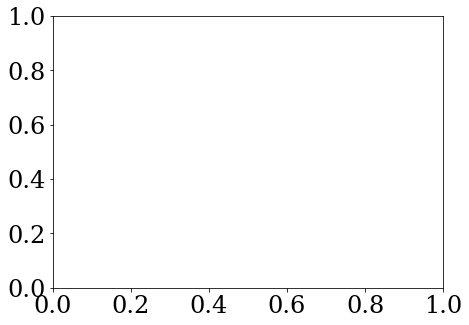

In [377]:
plt.errorbar(np.arange(0,10), mean_costs_all, std_costs_all, linestyle='None', marker='^')
plt.title('Кросс-энтропия S и ее дисперсия на обучении в зависимости от колическтва кластеров')
plt.xlabel('Количество кластеров')
plt.savefig('7.png')

In [179]:
def select_features(w, Xb, feat_threshold, cols):
    # Returns features with low variance
    inverse_of_A = np.dot(w.reshape(Xb.shape[1],1), w.reshape(1,Xb.shape[1]))/Xb.shape[1]
#     cov_w_matrix = np.linalg.pinv(inverse_of_A)
    cov_w_matrix = np.linalg.pinv(inverse_of_A)
    var_w = cov_w_matrix.diagonal()

    print('var_w')
    print(var_w)
    print('w')
    print(w)     
    print(cols)
    print(Xb[:, -5:])
    print(Xb.shape)
    mask2 = np.abs(var_w)<feat_threshold
    cols = [col for col, mask in zip(cols, mask2) if mask]
    w = w[mask2]
    Xb = Xb[:, mask2]
    
    return cols, w, Xb

In [159]:
def fit_with_obj_feat_selection_MF(X, T, iterations, obj_threshold, feat_threshold, n_clusters):
    
    X_ = copy.deepcopy(X)
    T_ = copy.deepcopy(T)
        
    N = X_.shape[0]
    D = X_.shape[1]
    
    Xb = preprocess(X_)
    Xb = np.hstack((Xb, np.zeros((Xb.shape[0], n_clusters))))
    
    cols = [str(i) for i in range(D + 1)] + ["cluster_" + str(x) for x in range(n_clusters)]
#     w = np.random.randn(D + 1 + n_clusters)
#     w = np.ones(D+1 + n_clusters)*math.log(T.mean()/(1-T.mean()))*0.02 + np.random.randn(D + 1 + n_clusters)*0.06
    w = np.array([-0.03650337, -0.0107314,  -0.00234493, -0.00433932, -0.03974928, -0.02914917,
 -0.01633966, -0.00345402, -0.03254841, -0.0266781,  -0.04509162, -0.04688906,
 -0.00671441,  0.00415988, -0.02440513, -0.00289427, -0.0157322 , -0.03586732,
 -0.01573701,  0.00779581, -0.02368145,  0.00832795, -0.07535983 ,-0.00652688,
 -0.02122398, -0.02894507,  0.01779581, -0.03368145,  0.00632795, -0.17535983 ,-0.00152688][:D+1+n_clusters]) + np.random.randn(D + 1 + n_clusters)[:D+1+n_clusters]*0.007
#     w = np.ones(D+1 + n_clusters)*-0.02710948

    list_w = []
    list_var_w = []
    list_var_obj = []
    costs = []

    for i in range(iterations):
        
#         if i==0:
#             print('Нулевые веса')
#             print(w)
        
        if n_clusters == 0:
            cluster_centers = []
            metric_mask = []
        
        if i!=0:
            cols, w, Xb = select_features(w, Xb, feat_threshold, cols)

            if n_clusters != 0:
    #             Для первой итерации фиксируем кол-во признаков для кластеризации: .fit(Xb[: ,:сколько-то признаков])
                not_metric_features = ['cluster_' not in x for x in cols]
                kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(Xb[:, not_metric_features])

                bc = np.bincount(kmeans.labels_)
                new_order = sorted(range(n_clusters), key=lambda x: bc[x])
                new_centroids = np.array([kmeans.cluster_centers_[i] for i in new_order])

                metric_features = pairwise_distances(Xb[:, not_metric_features], new_centroids)
                scaler = StandardScaler()
                metric_features = scaler.fit_transform(metric_features)
#                 print(i)
#                 print('metric_features')
#                 print(metric_features)

                cluster_centers = new_centroids
                print(bc)
                print(new_order)

                new_metric_cols = ['cluster_'+str(x) for x in range(metric_features.shape[1])]

                # Кластера из предыдущей итерации
                metric_cols = [x for x in cols if 'cluster_' in x]
                # metric_cols = new_metric_cols[metric_mask]
                metric_mask = [x in metric_cols for x in new_metric_cols]
                # Маска длины cols для кластеров, True только там, где кластера.
                # Позволяет выделить измененные на предыдущей итерации метрические признаки
                metric_all_mask = ['cluster_' in x for x in cols]
                Xb[:, metric_all_mask] = metric_features[:, metric_mask]

        # Модель
        Y_hat = sigmoid(Xb.dot(w))
        Y = Y_hat
        Y[Y==1.0] = 0.999999
        Y[Y==0.0] = 0.000001
        
#         print('YYYYYYYYYYYY')
#         print(Y)
        
        Xb, Y, T_ = select_objects(Y, obj_threshold, Xb, T_)
        
        costs += [cross_entropy(T_, Y)]
            
#         cols, w, Xb = select_features(w, Xb, feat_threshold, cols)

        w, var_w, b = step_of_NR_algo(Y, w, Xb, T_)

        list_w.append(w)
        list_var_w.append(var_w)
        list_var_obj.append(b)
        
        
        #print(w)
        #print(i)

    return w, list_w, list_var_w, list_var_obj, costs, cols, metric_mask, cluster_centers

In [ ]:
# X = X_train_processed[:, :20]
# X_test = X_test_processed[:, :20]
# T = np.array(Y_train)

costs_all = []
rocs_all = []
for n_clusters in [0,4,6,8,10]:
    costs = []
    rocs_val = []
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):
    #     print('ИТЕРАЦИЯ', i)
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_val = X[train_index], X[test_index]
        t_train, t_val = T[train_index], T[test_index]
        w3, list_w3, list_var_w3, list_var_obj3, costs3, cols3, metric_mask3, cluster_centers3 = fit_with_obj_feat_selection_MF(X=X_train, T=t_train, iterations=8, 
    #                                                                             obj_threshold=0.2499,
                                                                                        obj_threshold=100000000.0, 
                                                                                        feat_threshold=1.0*1e+20, 
    #                                                                                     feat_threshold=9.5*1e+00,        
                                                                                        n_clusters=n_clusters)
        
        pred3 = predict_estimates_with_MF(X_val, w3, cols=cols3, cluster_centers=cluster_centers3, metric_mask=metric_mask3)
        roc = roc_auc_score(t_val, pred3)
        rocs_val.append(copy.deepcopy(roc))
        
        costs.append(copy.deepcopy(costs3[-1]))
        
    costs_all.append(costs)
    rocs_all.append(rocs_val)

In [227]:
costs_all

[[0.3304555540205109,
  0.31938068113457946,
  0.3218361541346727,
  0.3220249843585223,
  0.32235262322876784],
 [6.743993560671017,
  6.473958528930392,
  6.323354280606641,
  6.093941240924529,
  6.392909917848229],
 [0.32566446892228185,
  0.3192766376091141,
  13.125745669264901,
  9.454522795302339,
  0.32533424086997437],
 [0.32293166646313504,
  0.3288662464130686,
  0.3196061145754296,
  0.34825635948012257,
  0.3175590795820814],
 [0.32303529329277414,
  0.3156689098981029,
  0.3177279683492837,
  0.31786190285198856,
  0.31836336359210415]]

In [228]:
mean_costs_all = np.array(costs_all).mean(axis=1)
std_costs_all = np.array(costs_all).std(axis=1)

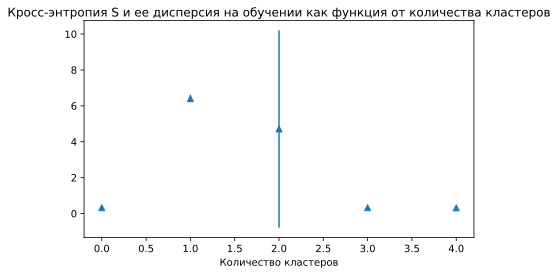

In [230]:
plt.errorbar([0,1,2,3,4], mean_costs_all, std_costs_all, linestyle='None', marker='^')
plt.title('Кросс-энтропия S и ее дисперсия на обучении как функция от количества кластеров')
plt.xlabel('Количество кластеров')
plt.savefig('7.png')

In [217]:
mean_r_all = np.array(rocs_all).mean(axis=1)
std_r_all = np.array(rocs_all).std(axis=1)

In [218]:
std_r_all

array([0.00571089, 0.19982035, 0.00487977, 0.00449708])

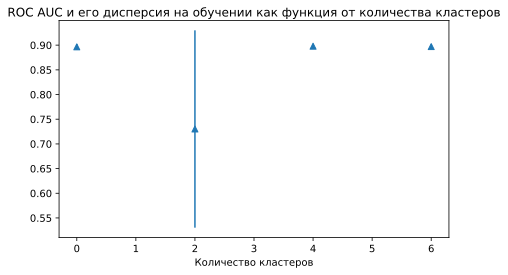

In [219]:
plt.errorbar([0,2,4,6], mean_r_all, std_r_all, linestyle='None', marker='^')
plt.title('ROC AUC и его дисперсия на обучении как функция от количества кластеров')
plt.xlabel('Количество кластеров')
plt.savefig('8.png')

In [144]:
w3, list_w3, list_var_w3, list_var_obj3, costs3, cols3, metric_mask3, cluster_centers3 = fit_with_obj_feat_selection_MF(X=X, T=T, iterations=10, 
#                                                                             obj_threshold=0.2499,
                                                                                    obj_threshold=100000000.0, 
                                                                                    feat_threshold=1.0*1e+20, 
#                                                                                     feat_threshold=9.5*1e+00,        
                                                                                    n_clusters=5)

Нулевые веса
[ 0.03765963 -0.04629807  0.0432905   0.06759209  0.02048195  0.09364999
 -0.03887926 -0.06242253 -0.08912581  0.07461242  0.03252848 -0.00296903
  0.01380863 -0.05646425  0.1220978   0.00627126  0.00527994  0.03609853
  0.02386066  0.0110044  -0.03971352  0.02338362  0.09391143  0.0670812
  0.07946953 -0.02575058 -0.04967004 -0.00647915  0.00259645  0.05451978]
YYYYYYYYYYYY
[0.43370664 0.49492897 0.48127326 ... 0.44684609 0.74409383 0.49579288]
[ 0.03765963 -0.04629807  0.0432905   0.06759209  0.02048195  0.09364999
 -0.03887926 -0.06242253 -0.08912581  0.07461242  0.03252848 -0.00296903
  0.01380863 -0.05646425  0.1220978   0.00627126  0.00527994  0.03609853
  0.02386066  0.0110044  -0.03971352  0.02338362  0.09391143  0.0670812
  0.07946953 -0.02575058 -0.04967004 -0.00647915  0.00259645  0.05451978]
[0.43370664 0.49492897 0.48127326 ... 0.44684609 0.74409383 0.49579288]
var_w
[-1.32449693e+19  6.79656007e+19 -1.56202585e+20 -1.33747464e+19
  2.07381826e+21 -5.15416425e

5
metric_features
[[-1.62445721 -0.85330042  0.23494055 -1.67410019 -0.49181439]
 [-0.96917997 -0.68077656  0.05541697 -1.88639921 -0.95366132]
 [ 0.20442021 -0.47016133 -0.36760391 -0.94321775 -0.05597576]
 ...
 [-1.20618667 -1.32565583 -0.51423379 -0.82938452 -0.79308244]
 [ 1.07411446  0.67631718 -0.30470351  0.9768206  -0.43653887]
 [ 0.01710838  0.93507853  0.42304681  0.82679856 -0.44910183]]
[1422  934  861  858  983]
[3, 2, 1, 4, 0]
YYYYYYYYYYYY
[0.63276997 0.57010015 0.44011762 ... 0.41004036 0.65290575 0.66397717]
[-0.05778462 -0.03230264  0.28911351 -0.17616182  0.16550088  0.12517965
  0.03071604  0.32588011  0.39202897 -0.17810513 -0.36391372  0.51329564
 -0.40260998  0.81015659 -0.36496196]
[0.63276997 0.57010015 0.44011762 ... 0.41004036 0.65290575 0.66397717]
var_w
[-5.40454134e+18  1.72234371e+18 -3.39796479e+17 -6.22543248e+17
 -2.11264110e+18 -2.52179470e+17  1.18109312e+19 -3.91434638e+17
  8.24084795e+15 -1.26784411e+18  4.53871389e+16 -7.20866518e+16
 -9.07178757e

10
metric_features
[[-1.62445721 -0.85330042  0.23494055 -1.67410019 -0.49181439]
 [-0.96917997 -0.68077656  0.05541697 -1.88639921 -0.95366132]
 [ 0.20442021 -0.47016133 -0.36760391 -0.94321775 -0.05597576]
 ...
 [-1.20618667 -1.32565583 -0.51423379 -0.82938452 -0.79308244]
 [ 1.07411446  0.67631718 -0.30470351  0.9768206  -0.43653887]
 [ 0.01710838  0.93507853  0.42304681  0.82679856 -0.44910183]]
[1422  934  861  858  983]
[3, 2, 1, 4, 0]
YYYYYYYYYYYY
[0.61383127 0.58463833 0.5058158  ... 0.39460076 0.76184923 0.51931394]
[-0.23522782 -0.0622182   0.44933746 -0.30640218  0.30814179  0.192946
  0.049028    0.44042478  0.52438828 -0.21218285 -0.50346791  0.9054265
 -0.52299499  0.64880773 -0.4190888 ]
[0.61383127 0.58463833 0.5058158  ... 0.39460076 0.76184923 0.51931394]
var_w
[-3.71125841e+18 -1.61736139e+19 -1.08104012e+18 -3.77797523e+18
 -1.90323756e+18 -1.40833124e+19  1.68135195e+19 -2.50090956e+18
 -1.98680386e+17 -6.62616795e+18 -1.09800479e+18 -9.25287216e+16
 -3.16841570e+1

 [-3.1433165  -0.67774546  0.94062238  0.04310061 -0.43430638]]
(5058, 14)
15
metric_features
[[-0.77097743 -1.51994485  0.35837327 -1.54379434 -0.3439265 ]
 [-0.429098   -0.81589469  0.14253425 -1.73659653 -0.78317957]
 [-0.39837245  0.19599487 -0.4942095  -1.07650753 -0.05602618]
 ...
 [-1.36914728 -1.19032792 -0.45812219 -0.82023619 -0.76455263]
 [ 0.89513486  1.1335713  -0.41554186  1.03138673 -0.46563026]
 [ 0.68772805 -0.09919427  0.53703505  0.76770602 -0.60287435]]
[1423 1038  736 1009  852]
[2, 4, 3, 1, 0]
YYYYYYYYYYYY
[0.57814266 0.55422115 0.38964706 ... 0.37363865 0.69875847 0.62558613]
[-0.24978431  0.43207001 -0.29649636  0.30194696  0.39849473  0.47405931
 -0.18913358 -0.4555667   0.89608825  0.65047258 -0.65149596 -0.375848  ]
[0.57814266 0.55422115 0.38964706 ... 0.37363865 0.69875847 0.62558613]
var_w
[-5.35023099e+17 -6.58925615e+17  3.74841484e+17 -1.41732635e+18
 -2.49422262e+18 -7.08457470e+17 -1.35185735e+17 -1.12157967e+17
 -7.17653549e+17 -3.18736657e+17 -4.381

21
metric_features
[[-0.77097743 -1.51994485  0.35837327 -1.54379434 -0.3439265 ]
 [-0.429098   -0.81589469  0.14253425 -1.73659653 -0.78317957]
 [-0.39837245  0.19599487 -0.4942095  -1.07650753 -0.05602618]
 ...
 [-1.36914728 -1.19032792 -0.45812219 -0.82023619 -0.76455263]
 [ 0.89513486  1.1335713  -0.41554186  1.03138673 -0.46563026]
 [ 0.68772805 -0.09919427  0.53703505  0.76770602 -0.60287435]]
[1423 1038  736 1009  852]
[2, 4, 3, 1, 0]
YYYYYYYYYYYY
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
[-0.13062952  0.65975879 -0.38713929  0.45769727  0.60396127  0.72284235
 -0.28988958 -0.6147491   1.17610112  0.60023341 -0.49435856 -0.35653145]
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
var_w
[-1.18064394e+19 -1.50032777e+17  6.48287041e+16  2.02569303e+17
 -5.16074845e+16 -1.19100632e+16 -2.33341127e+17 -7.54855388e+17
 -4.17832655e+16  3.99560759e+17 -1.23918575e+17 -1.69459737e+18]
w
[-0.13062952  0.65975879 -0.38713929  0.457697

27
metric_features
[[-0.77097743 -1.51994485  0.35837327 -1.54379434 -0.3439265 ]
 [-0.429098   -0.81589469  0.14253425 -1.73659653 -0.78317957]
 [-0.39837245  0.19599487 -0.4942095  -1.07650753 -0.05602618]
 ...
 [-1.36914728 -1.19032792 -0.45812219 -0.82023619 -0.76455263]
 [ 0.89513486  1.1335713  -0.41554186  1.03138673 -0.46563026]
 [ 0.68772805 -0.09919427  0.53703505  0.76770602 -0.60287435]]
[1423 1038  736 1009  852]
[2, 4, 3, 1, 0]
YYYYYYYYYYYY
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
[-0.13062952  0.65975879 -0.38713929  0.45769727  0.60396127  0.72284235
 -0.28988958 -0.6147491   1.17610112  0.60023341 -0.49435856 -0.35653145]
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
var_w
[1.69022266e+18 1.07903409e+16 1.39148110e+18 3.95128353e+17
 2.94152803e+17 5.48134796e+17 1.57156109e+18 1.95159583e+17
 7.62479354e+16 2.90805077e+17 8.67568530e+16 2.49620056e+18]
w
[-0.13062952  0.65975879 -0.38713929  0.45769727  0.603961

33
metric_features
[[-0.77097743 -1.51994485  0.35837327 -1.54379434 -0.3439265 ]
 [-0.429098   -0.81589469  0.14253425 -1.73659653 -0.78317957]
 [-0.39837245  0.19599487 -0.4942095  -1.07650753 -0.05602618]
 ...
 [-1.36914728 -1.19032792 -0.45812219 -0.82023619 -0.76455263]
 [ 0.89513486  1.1335713  -0.41554186  1.03138673 -0.46563026]
 [ 0.68772805 -0.09919427  0.53703505  0.76770602 -0.60287435]]
[1423 1038  736 1009  852]
[2, 4, 3, 1, 0]
YYYYYYYYYYYY
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
[-0.13062952  0.65975879 -0.38713929  0.45769727  0.60396127  0.72284235
 -0.28988958 -0.6147491   1.17610112  0.60023341 -0.49435856 -0.35653145]
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
var_w
[-1.31035162e+19 -2.09897792e+17  9.26093020e+17  3.03920675e+17
 -6.02849432e+16 -1.71717316e+15  4.68197217e+17  1.90699471e+17
  7.20910424e+16 -8.02258086e+16  1.00205198e+18  2.59345360e+17]
w
[-0.13062952  0.65975879 -0.38713929  0.457697

39
metric_features
[[-0.77097743 -1.51994485  0.35837327 -1.54379434 -0.3439265 ]
 [-0.429098   -0.81589469  0.14253425 -1.73659653 -0.78317957]
 [-0.39837245  0.19599487 -0.4942095  -1.07650753 -0.05602618]
 ...
 [-1.36914728 -1.19032792 -0.45812219 -0.82023619 -0.76455263]
 [ 0.89513486  1.1335713  -0.41554186  1.03138673 -0.46563026]
 [ 0.68772805 -0.09919427  0.53703505  0.76770602 -0.60287435]]
[1423 1038  736 1009  852]
[2, 4, 3, 1, 0]
YYYYYYYYYYYY
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
[-0.13062952  0.65975879 -0.38713929  0.45769727  0.60396127  0.72284235
 -0.28988958 -0.6147491   1.17610112  0.60023341 -0.49435856 -0.35653145]
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
var_w
[-3.55013835e+17 -1.75899280e+16 -2.10377682e+17 -3.24666293e+17
 -1.95510153e+17 -2.50086645e+16  1.74715568e+17 -8.05553298e+16
 -1.99738243e+16 -2.81771553e+16  5.35973205e+16 -1.45165067e+17]
w
[-0.13062952  0.65975879 -0.38713929  0.457697

45
metric_features
[[-0.77097743 -1.51994485  0.35837327 -1.54379434 -0.3439265 ]
 [-0.429098   -0.81589469  0.14253425 -1.73659653 -0.78317957]
 [-0.39837245  0.19599487 -0.4942095  -1.07650753 -0.05602618]
 ...
 [-1.36914728 -1.19032792 -0.45812219 -0.82023619 -0.76455263]
 [ 0.89513486  1.1335713  -0.41554186  1.03138673 -0.46563026]
 [ 0.68772805 -0.09919427  0.53703505  0.76770602 -0.60287435]]
[1423 1038  736 1009  852]
[2, 4, 3, 1, 0]
YYYYYYYYYYYY
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
[-0.13062952  0.65975879 -0.38713929  0.45769727  0.60396127  0.72284235
 -0.28988958 -0.6147491   1.17610112  0.60023341 -0.49435856 -0.35653145]
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
var_w
[ 1.58223622e+18  4.04363417e+16  1.58781803e+17 -1.34477863e+17
 -2.22216415e+16 -3.62703107e+16 -1.90841025e+17  4.07729533e+16
  7.75926086e+15  3.70295429e+17  3.67623075e+17 -1.85285711e+17]
w
[-0.13062952  0.65975879 -0.38713929  0.457697

51
metric_features
[[-0.77097743 -1.51994485  0.35837327 -1.54379434 -0.3439265 ]
 [-0.429098   -0.81589469  0.14253425 -1.73659653 -0.78317957]
 [-0.39837245  0.19599487 -0.4942095  -1.07650753 -0.05602618]
 ...
 [-1.36914728 -1.19032792 -0.45812219 -0.82023619 -0.76455263]
 [ 0.89513486  1.1335713  -0.41554186  1.03138673 -0.46563026]
 [ 0.68772805 -0.09919427  0.53703505  0.76770602 -0.60287435]]
[1423 1038  736 1009  852]
[2, 4, 3, 1, 0]
YYYYYYYYYYYY
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
[-0.13062952  0.65975879 -0.38713929  0.45769727  0.60396127  0.72284235
 -0.28988958 -0.6147491   1.17610112  0.60023341 -0.49435856 -0.35653145]
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
var_w
[ 1.73578577e+18 -7.82895193e+16  2.18077034e+16 -2.84838431e+16
  3.50425368e+17  5.54660277e+16  2.26472823e+17  4.84511915e+16
  2.27262613e+16  3.12555351e+17 -4.80610849e+15 -2.75208575e+17]
w
[-0.13062952  0.65975879 -0.38713929  0.457697

57
metric_features
[[-0.77097743 -1.51994485  0.35837327 -1.54379434 -0.3439265 ]
 [-0.429098   -0.81589469  0.14253425 -1.73659653 -0.78317957]
 [-0.39837245  0.19599487 -0.4942095  -1.07650753 -0.05602618]
 ...
 [-1.36914728 -1.19032792 -0.45812219 -0.82023619 -0.76455263]
 [ 0.89513486  1.1335713  -0.41554186  1.03138673 -0.46563026]
 [ 0.68772805 -0.09919427  0.53703505  0.76770602 -0.60287435]]
[1423 1038  736 1009  852]
[2, 4, 3, 1, 0]
YYYYYYYYYYYY
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
[-0.13062952  0.65975879 -0.38713929  0.45769727  0.60396127  0.72284235
 -0.28988958 -0.6147491   1.17610112  0.60023341 -0.49435856 -0.35653145]
[0.65613202 0.59660393 0.43880332 ... 0.39056198 0.75845313 0.63814805]
var_w
[-2.75761923e+18 -1.20304049e+17  1.28950051e+17  3.92918331e+17
 -3.26556390e+17 -3.85240627e+16 -1.39007241e+17 -9.57893213e+16
  2.30887380e+16  8.43613304e+16 -3.45053637e+17 -6.31439115e+17]
w
[-0.13062952  0.65975879 -0.38713929  0.457697

In [162]:
feat_threshold=1.0*1e+20

In [165]:
#Good parameters
# w3, list_w3, list_var_w3, list_var_obj3, costs3, cols3, metric_mask3, cluster_centers3 = fit_with_obj_feat_selection_MF(X=X, T=T, iterations=60, 
# #                                                                             obj_threshold=0.2499,
#                                                                                     obj_threshold=100000000.0, 
#                                                                                     feat_threshold=1.0*1e+20, 
# #                                                                                     feat_threshold=9.5*1e+00,        
#                                                                                     n_clusters=5)

UsageError: Unknown variable 'w3,'


In [128]:
cols3, len(cols3)

(['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '20',
  'cluster_0',
  'cluster_1',
  'cluster_3',
  'cluster_4'],
 25)

In [129]:
# plt.bar(np.arange(len(w3)), w3)
# plt.xticks(np.arange(len(w3)), cols3)

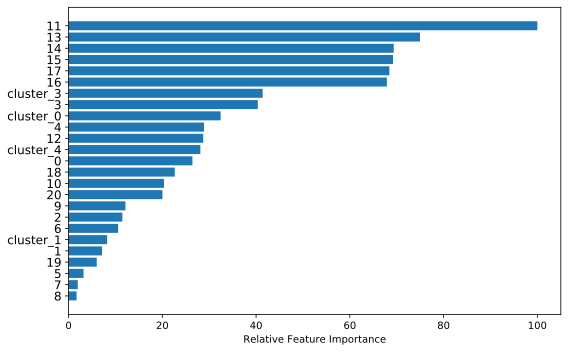

In [130]:
feature_importance = abs(w3)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(8, 5))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(cols3)[sorted_idx], fontsize=12)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   

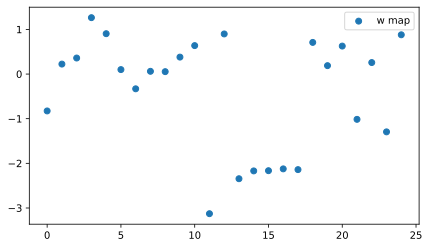

In [131]:
plot_weights(w3)

In [296]:
pred3 = predict_estimates_with_MF(X_test, w3, cols=cols3, cluster_centers=cluster_centers3, metric_mask=metric_mask3)

In [297]:
roc_auc_score(t_test, pred3)

0.740014698806511

In [298]:
fpr, tpr, thresholds = metrics.roc_curve(t_test, pred3, pos_label=None)

In [324]:
from utils import *

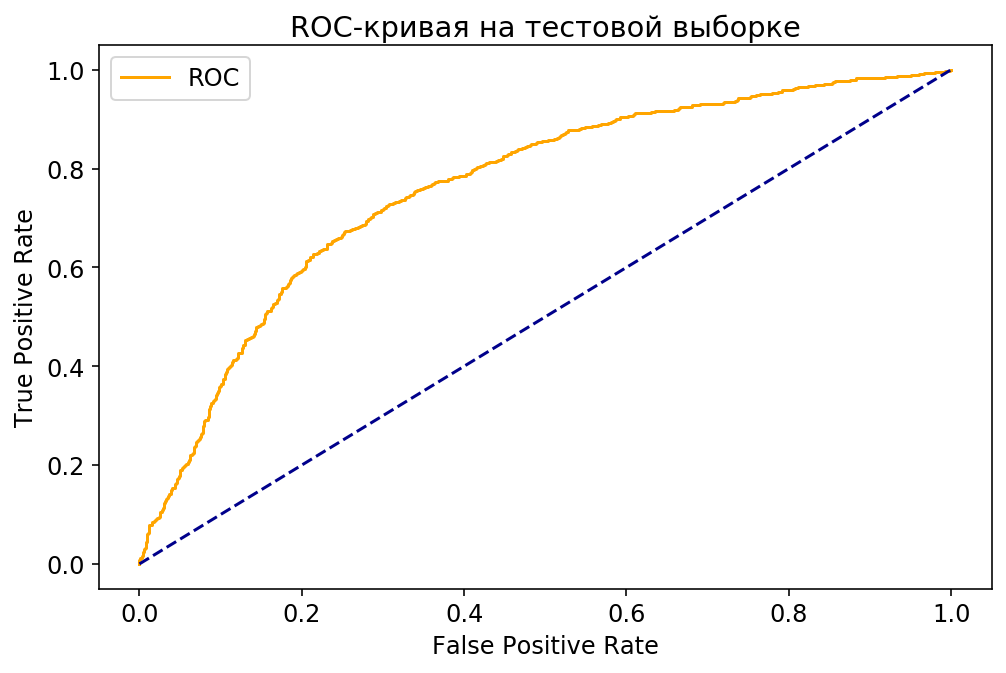

In [325]:
plot_roc_cur(fpr, tpr, title='ROC-кривая на тестовой выборке')

Text(0.5, 1.0, 'Зависимость S от номера итерации')

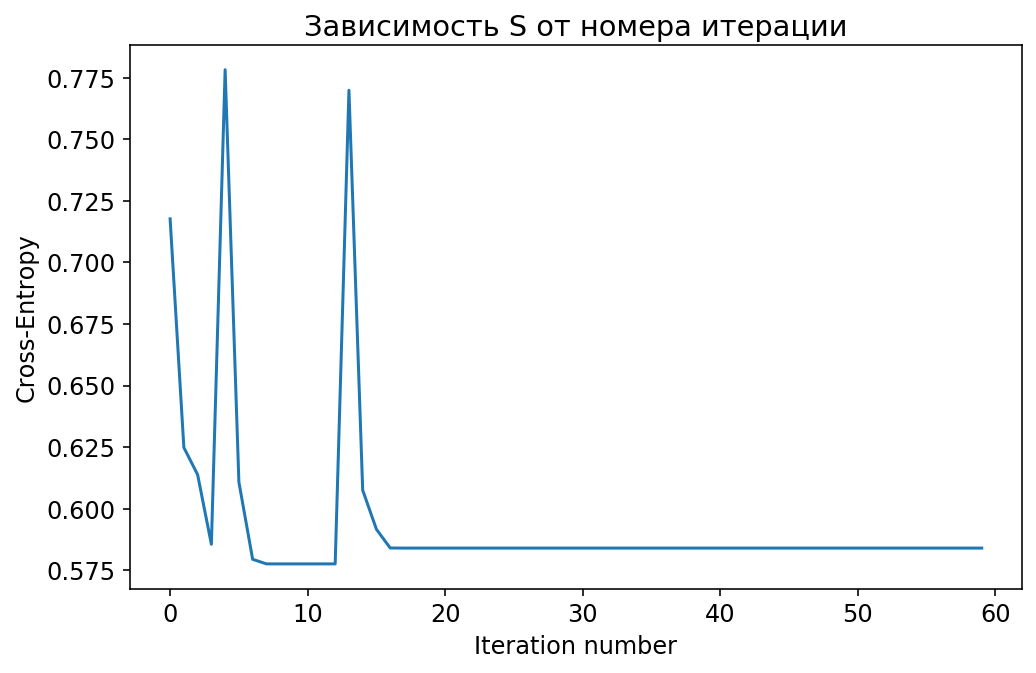

In [300]:
plt.plot(np.arange(len(costs3)),costs3)
plt.xlabel('Iteration number')
plt.ylabel('Cross-Entropy')
plt.title('Зависимость S от номера итерации')

Text(0.5, 1.0, 'Зависимость exp(-S) от номера итерации')

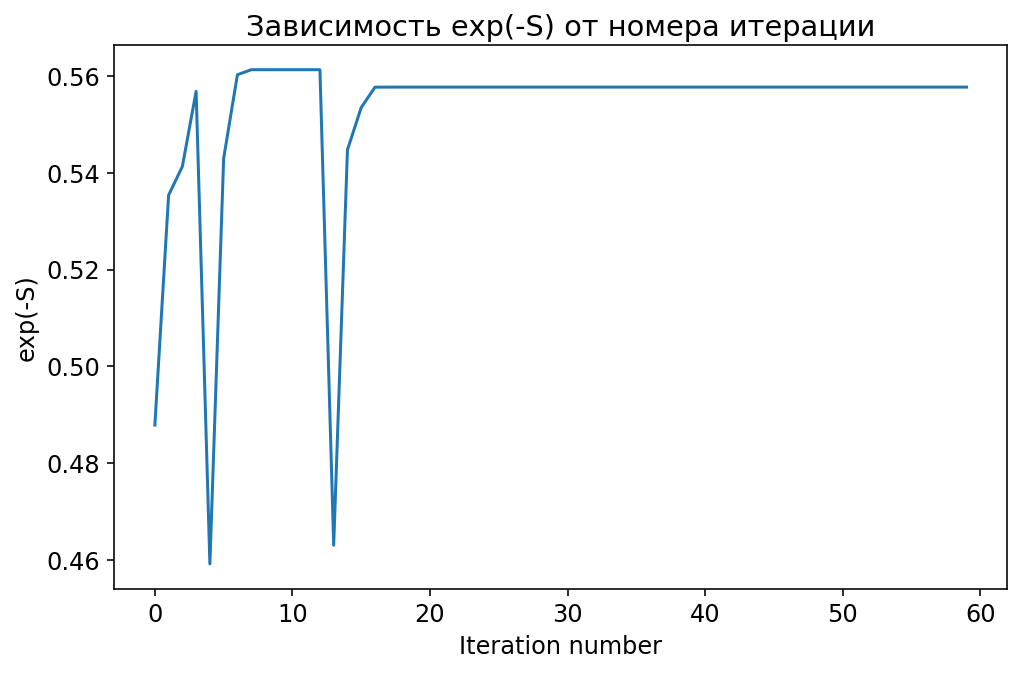

In [301]:
plt.plot(np.arange(len(costs3)),np.exp(-np.array(costs3)))
plt.xlabel('Iteration number')
plt.ylabel('exp(-S)')
plt.title('Зависимость exp(-S) от номера итерации')

In [302]:
def var_of_w(l, i):
    res = []
    for item in l:
        if len(item) > i:
            res.append(item[i])
    return res

In [303]:
cols3

['0',
 '6',
 '7',
 '10',
 '16',
 '17',
 '18',
 '19',
 '22',
 'cluster_0',
 'cluster_1',
 'cluster_4']

Text(0.5, 1.0, 'Зависимость нешумовых параметров модели w от номера итерации')

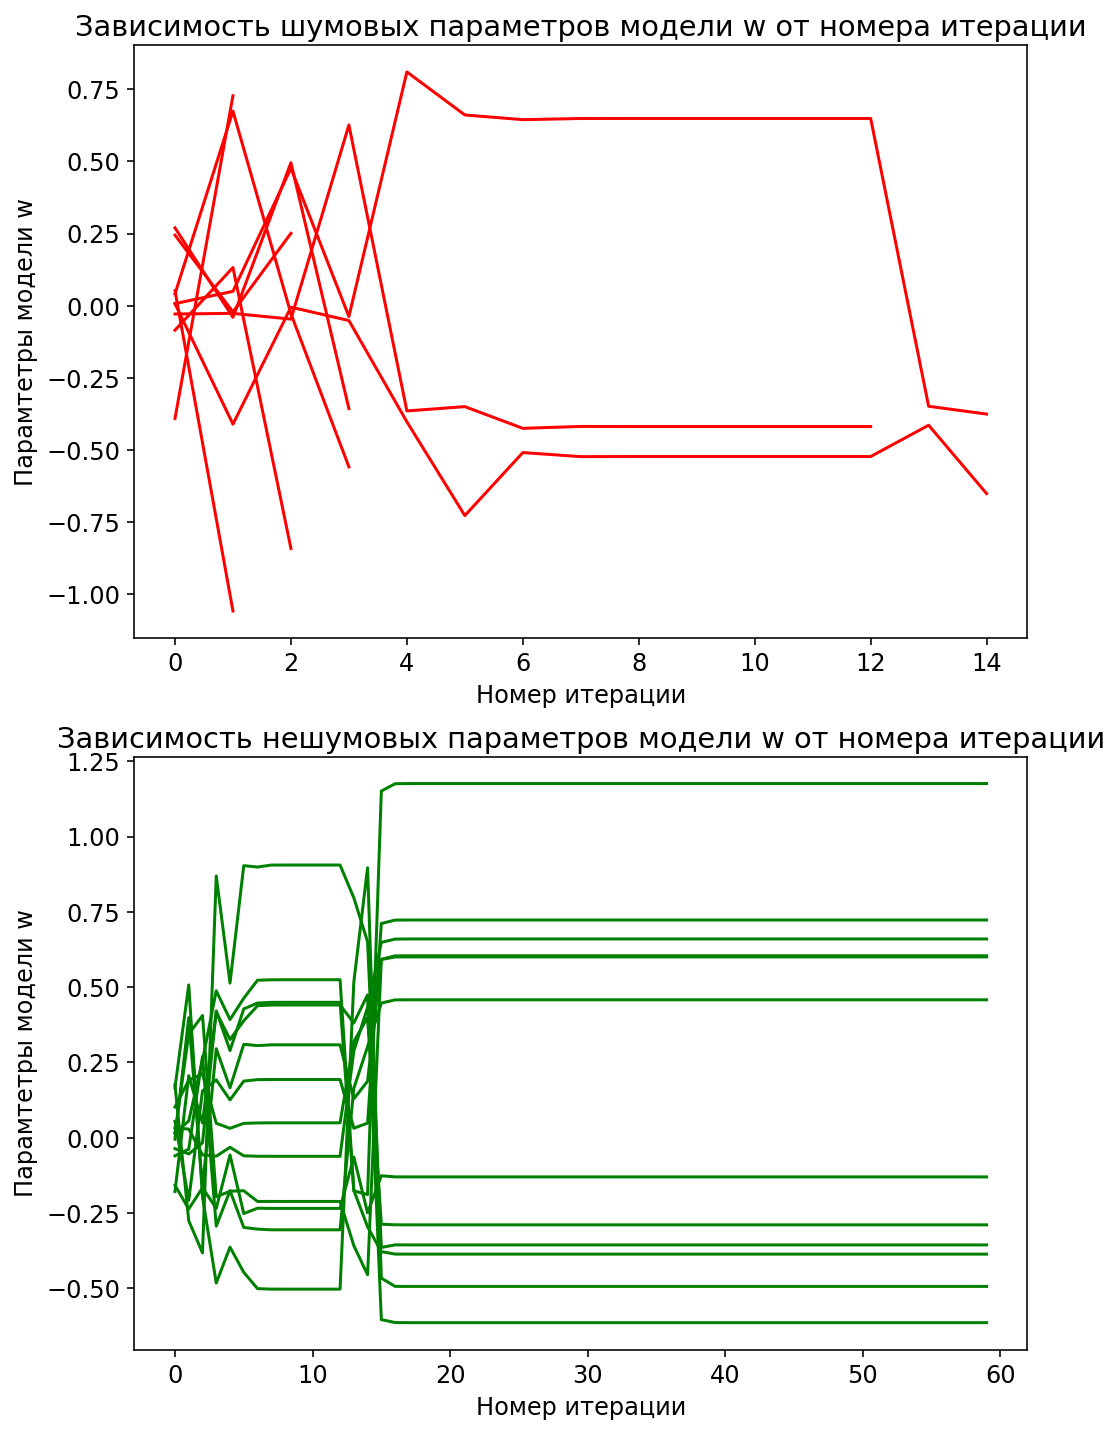

In [304]:
plt.figure(figsize=(8,12))
plt.subplot(211)
for i in range(len(list_w3[0])):
    if len(var_of_w(list_w3, i))<len(var_of_w(list_w3, 0)):
        plt.plot(var_of_w(list_w3, i), color='r')
plt.xlabel('Номер итерации')
plt.ylabel('Парамтетры модели w')
plt.title('Зависимость информативныхых параметров модели w от номера итерации')
plt.subplot(212)
for i in range(len(list_w3[0])):
    if len(var_of_w(list_w3, i))>=len(var_of_w(list_w3, 0)):
        plt.plot(var_of_w(list_w3, i), color='g')
plt.xlabel('Номер итерации')
plt.ylabel('Парамтетры модели w')
plt.title('Зависимость неинформативных параметров модели w от номера итерации')

Text(0.5, 1.0, 'Зависимость нешумовых элементов матрицы A от номера итерации')

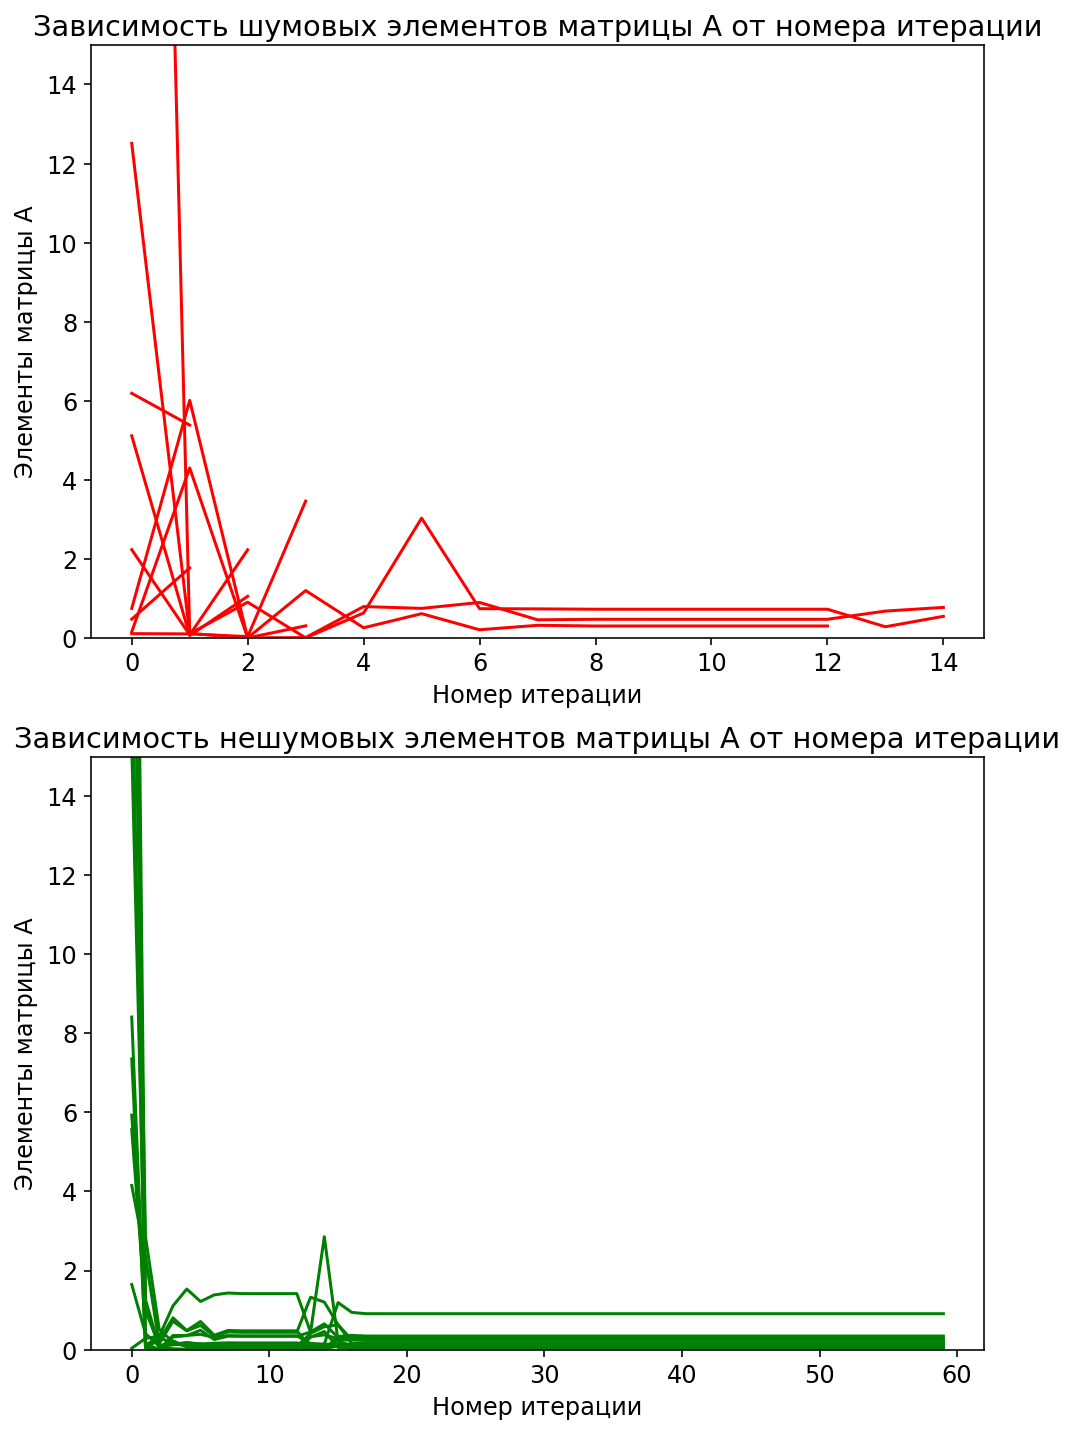

In [319]:
plt.figure(figsize=(8,12))
plt.subplot(211)
for i in range(len(list_var_w3[0])):
    if len(var_of_w(list_var_w3, i))<len(var_of_w(list_var_w3, 0)):
        plt.plot(var_of_w(list_var_w3, i), color='r')
        plt.ylim(0,15)
plt.xlabel('Номер итерации')
plt.ylabel('Элементы матрицы A')
plt.title('Зависимость информативных элементов матрицы A от номера итерации')
plt.subplot(212)
for i in range(len(list_var_w3[0])):
    if len(var_of_w(list_var_w3, i))>=len(var_of_w(list_var_w3, 0)):
        plt.plot(var_of_w(list_var_w3, i), color='g')
        plt.ylim(0,15)
plt.xlabel('Номер итерации')
plt.ylabel('Элементы матрицы A')
plt.title('Зависимость неинформативных элементов матрицы A от номера итерации')

In [306]:
model = LogisticRegression(random_state=0)
model.fit(X, T)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [307]:
y_scores = model.predict_proba(X_test)[:, 1]

In [308]:
from sklearn.metrics import roc_auc_score
print('AUC-ROC', roc_auc_score(t_test, y_scores))

AUC-ROC 0.761931508199319


In [309]:
fpr, tpr, thresholds = metrics.roc_curve(t_test, y_scores, pos_label=None)

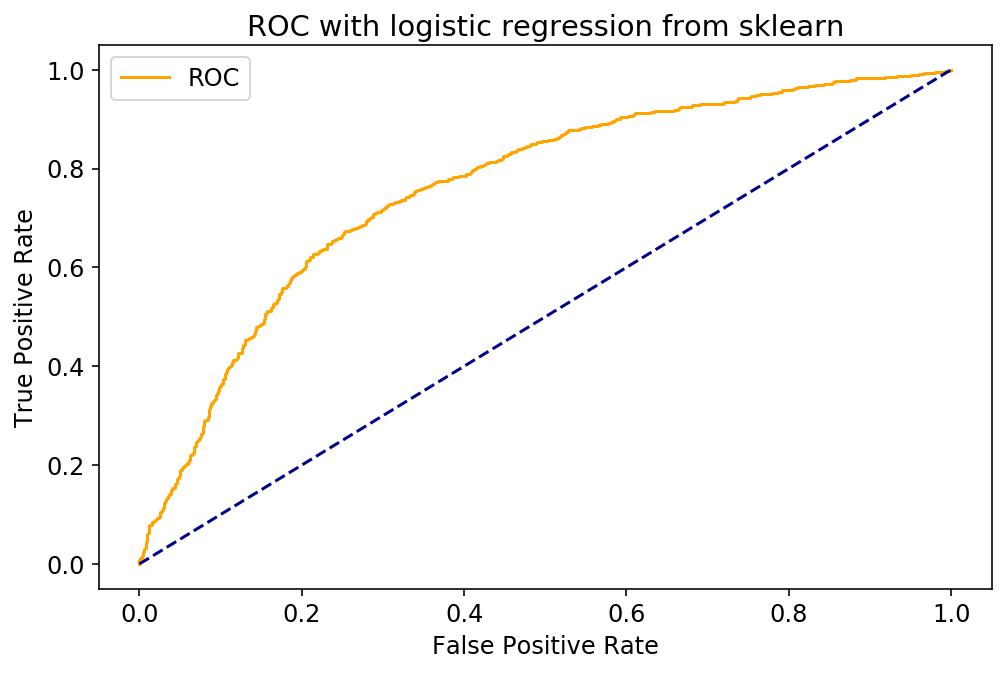

In [310]:
plot_roc_cur(fpr, tpr, title='ROC with logistic regression from sklearn')

In [311]:
coefs = np.abs(model.coef_[0])

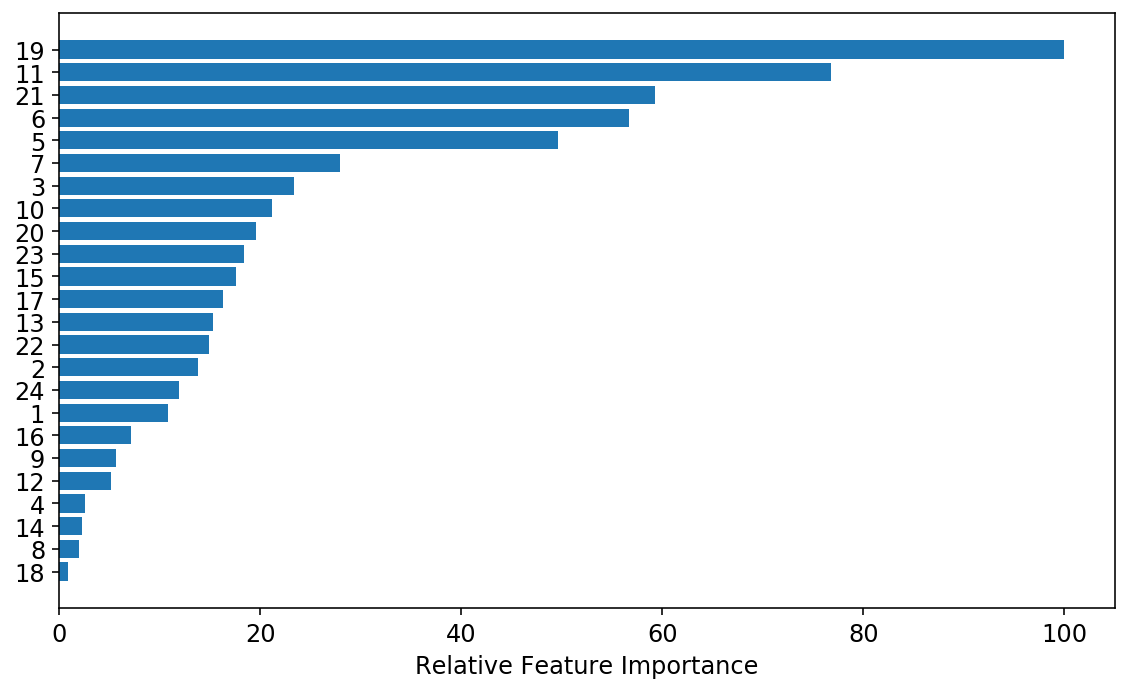

In [314]:
feature_importance = abs(coefs)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(8, 5))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array([i for i in range(1, len(coefs)+1)])[sorted_idx], fontsize=12)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   

In [315]:
ar = []
for x in zip(model.coef_[0], range(1, len(model.coef_[0]+1))):
    ar.append(x)

In [316]:
ar

[(0.02884190256929138, 1),
 (-0.03660332857156802, 2),
 (-0.062136891110611256, 3),
 (-0.006959391203323793, 4),
 (0.1316977143532688, 5),
 (-0.15049495560656845, 6),
 (-0.07423690852773168, 7),
 (0.005310721220262649, 8),
 (0.015066120786570098, 9),
 (0.05621064093753258, 10),
 (0.20401281647254432, 11),
 (0.01358054820358015, 12),
 (-0.04054838239203495, 13),
 (-0.006043896772392055, 14),
 (0.04681472305985809, 15),
 (0.019054383919492265, 16),
 (0.043429157255352, 17),
 (-0.002427092508821553, 18),
 (-0.26562863122667024, 19),
 (0.05200979104408491, 20),
 (0.1574091334836388, 21),
 (-0.03955509159077588, 22),
 (-0.04878421730842163, 23)]

### SelectFromModel

In [265]:
d1 = pd.DataFrame(X, columns=[str(i) for i in range(1, X.shape[1]+1)])
d2 = pd.DataFrame(X_test, columns=[str(i) for i in range(1, X_test.shape[1]+1)])

In [274]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"), max_features=12)
embeded_lr_selector.fit(d1, T)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = d1.loc[:,embeded_lr_support].columns.tolist()
print(embeded_lr_feature, str(len(embeded_lr_feature)), 'selected features')

['3', '5', '6', '7', '10', '11', '13', '17', '19', '20', '21', '23'] 12 selected features


C:\Users\Irina\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [293]:
set(embeded_lr_feature) & set(cols3), len(set(embeded_lr_feature) & set(cols3))

({'11', '19', '20', '21', '23', '5', '6'}, 7)

### Tree-based: SelectFromModel

In [275]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=12)
embeded_rf_selector.fit(d1, T)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = d1.loc[:,embeded_rf_support].columns.tolist()
print(embeded_lr_feature, str(len(embeded_rf_feature)), 'selected features')

['3', '5', '6', '7', '10', '11', '13', '17', '19', '20', '21', '23'] 10 selected features


In [294]:
set(embeded_lr_feature) & set(cols3), len(set(embeded_lr_feature) & set(cols3))

({'11', '19', '20', '21', '23', '5', '6'}, 7)

### Pearson Correlation

In [295]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [296]:
cor_support, cor_feature = cor_selector(d1, T, 12)
print(sorted([int(i) for i in cor_feature]), str(len(cor_feature)), 'selected features')

[5, 6, 7, 9, 10, 11, 15, 16, 19, 21, 22, 23] 12 selected features


In [307]:
set(cor_feature) & set(cols3), len(set(cor_feature) & set(cols3))

({'11', '15', '19', '21', '23', '5', '6'}, 7)

### Новая синтетическая выборка

In [552]:
ds = make_classification(n_samples=7550, n_features=24, n_informative=12, 
                         flip_y=0.33, random_state=42)

In [553]:
X, T = ds

In [554]:
X, X_test, T, t_test = train_test_split(X, T, test_size=0.33, random_state=42)

In [555]:
def fit_with_obj_feat_selection_MF(X, T, iterations, obj_threshold, feat_threshold, n_clusters):
    
    X_ = copy.deepcopy(X)
    T_ = copy.deepcopy(T)
        
    N = X_.shape[0]
    D = X_.shape[1]
    
    Xb = preprocess(X_)
    Xb = np.hstack((Xb, np.zeros((Xb.shape[0], n_clusters))))
    
    cols = [str(i) for i in range(D + 1)] + ["cluster_" + str(x) for x in range(n_clusters)]
#     w = np.random.randn(D + 1 + n_clusters)
    w = np.ones(D+1 + n_clusters)*math.log(T.mean()/(1-T.mean()))*0.02 + np.random.randn(D + 1 + n_clusters)*0.05
    w = np.array([ 0.09171938, -0.0113631,  -0.01765564 ,-0.00116078, -0.01534879,  0.0398073 ,
 -0.08100533 ,-0.05287392 ,-0.05357995 , 0.04732558 , 0.08534087, -0.00541226,
 -0.00863089 , 0.00331281  ,0.05790412, -0.04655746 , 0.01172865 , 0.04857008,
  0.02486491 , 0.00928928 , 0.0498625 , -0.13535141 , 0.03370397, -0.03289358,
 -0.09172144 , 0.02537033,  0.06849313, -0.00706223,  0.04745393 , 0.08042411])
#     w = np.ones(D+1 + n_clusters)*-0.02710948

    list_w = []
    list_var_w = []
    list_var_obj = []
    costs = []

    for i in range(iterations):
        
        if n_clusters == 0:
            cluster_centers = []
            metric_mask = []
        
        if i!=0:
            cols, w, Xb = select_features(w, Xb, feat_threshold, cols)

            if n_clusters != 0:
    #             Для первой итерации фиксируем кол-во признаков для кластеризации: .fit(Xb[: ,:сколько-то признаков])
                not_metric_features = ['cluster_' not in x for x in cols]
                kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(Xb[:, not_metric_features])

                bc = np.bincount(kmeans.labels_)
                new_order = sorted(range(n_clusters), key=lambda x: bc[x])
                new_centroids = np.array([kmeans.cluster_centers_[i] for i in new_order])

                metric_features = pairwise_distances(Xb[:, not_metric_features], new_centroids)
                scaler = StandardScaler()
                metric_features = scaler.fit_transform(metric_features)
                print(i)
                print('metric_features')
                print(metric_features)

                cluster_centers = new_centroids
                print(bc)
                print(new_order)

                new_metric_cols = ['cluster_'+str(x) for x in range(metric_features.shape[1])]

                # Кластера из предыдущей итерации
                metric_cols = [x for x in cols if 'cluster_' in x]
                # metric_cols = new_metric_cols[metric_mask]
                metric_mask = [x in metric_cols for x in new_metric_cols]
                # Маска длины cols для кластеров, True только там, где кластера.
                # Позволяет выделить измененные на предыдущей итерации метрические признаки
                metric_all_mask = ['cluster_' in x for x in cols]
                Xb[:, metric_all_mask] = metric_features[:, metric_mask]

        # Модель
        Y_hat = sigmoid(Xb.dot(w))
        Y = Y_hat
        Y[Y==1.0] = 0.999999
        Y[Y==0.0] = 0.000001
        
        print('YYYYYYYYYYYY')
        print(Y)
        
        Xb, Y, T_ = select_objects(Y, obj_threshold, Xb, T_)
        
        costs += [cross_entropy(T_, Y)]
            
#         cols, w, Xb = select_features(w, Xb, feat_threshold, cols)

        w, var_w, b = step_of_NR_algo(Y, w, Xb, T_)

        list_w.append(w)
        list_var_w.append(var_w)
        list_var_obj.append(b)
        
        
        #print(w)
        #print(i)

    return w, list_w, list_var_w, list_var_obj, costs, cols, metric_mask, cluster_centers

In [566]:
%%time
w3, list_w3, list_var_w3, list_var_obj3, costs3, cols3, metric_mask3, cluster_centers3 = fit_with_obj_feat_selection_MF(X=X, T=T, iterations=50, 
#                                                                             obj_threshold=0.2499,
                                                                                    obj_threshold=100000000.0, 
                                                                                    feat_threshold=1e+21, 
#                                                                                     feat_threshold=9.5*1e+00,        
                                                                                    n_clusters=5)

YYYYYYYYYYYY
[0.42864556 0.55936118 0.36604985 ... 0.38472596 0.55523473 0.49778558]
[ 0.09171938 -0.0113631  -0.01765564 -0.00116078 -0.01534879  0.0398073
 -0.08100533 -0.05287392 -0.05357995  0.04732558  0.08534087 -0.00541226
 -0.00863089  0.00331281  0.05790412 -0.04655746  0.01172865  0.04857008
  0.02486491  0.00928928  0.0498625  -0.13535141  0.03370397 -0.03289358
 -0.09172144  0.02537033  0.06849313 -0.00706223  0.04745393  0.08042411]
[0.42864556 0.55936118 0.36604985 ... 0.38472596 0.55523473 0.49778558]
var_w
[ 9.49347809e+17  1.25696995e+20  1.79605340e+20  4.07605115e+19
  3.75549494e+22  1.34923724e+19  3.88846731e+18 -8.18789690e+18
 -9.49525059e+20 -1.05141747e+19 -1.52081777e+22 -8.74234518e+17
 -3.11094466e+18 -1.65348135e+18  2.92752670e+20  1.37897583e+19
  3.89603390e+19  2.24643681e+20  1.84730243e+19 -1.16402740e+18
  3.54347762e+19  4.84430764e+18  3.47964589e+19 -1.90844445e+19
 -1.81362901e+20  1.61880174e+20 -5.35311782e+19 -8.50626818e+20
  2.14400983e+21 

4
metric_features
[[ 0.60811872  1.48741144 -0.94592246  0.7931137   0.26191342]
 [-0.40836087  0.31712716 -1.87969083 -0.41920047 -0.84401359]
 [-0.78120704  0.62802794 -1.08649998  0.00940565  0.46912457]
 ...
 [ 0.34709189 -1.09811886  0.92533147  0.13662768 -0.20312835]
 [ 0.32173166 -0.73191559  1.56713306 -0.28151382  0.96718294]
 [ 0.25928173  0.05522014  0.12311561 -0.98599956 -0.32138504]]
[ 732 1094 1171  905 1156]
[0, 3, 1, 4, 2]
YYYYYYYYYYYY
[0.48294025 0.57554309 0.50071956 ... 0.26231339 0.72945704 0.59481329]
[-0.31567559  0.03348604 -0.04669167 -0.06307858  0.18158404 -0.21100016
  0.03477395  0.1791539   0.03835212 -0.2014627   0.04613505 -0.2410806
 -0.12888418  0.11791757 -0.08048979  0.05671022  0.22007523 -0.16645142
 -0.04481679 -0.04076149 -0.37330353  1.18034726  0.35014357 -1.13520147]
[0.48294025 0.57554309 0.50071956 ... 0.26231339 0.72945704 0.59481329]
var_w
[ 9.93166380e+17 -3.34311679e+19 -6.76282665e+19  8.96997605e+18
 -3.42996512e+18  2.72839563e+18  1

8
metric_features
[[ 0.60811872  1.48741144 -0.94592246  0.7931137   0.26191342]
 [-0.40836087  0.31712716 -1.87969083 -0.41920047 -0.84401359]
 [-0.78120704  0.62802794 -1.08649998  0.00940565  0.46912457]
 ...
 [ 0.34709189 -1.09811886  0.92533147  0.13662768 -0.20312835]
 [ 0.32173166 -0.73191559  1.56713306 -0.28151382  0.96718294]
 [ 0.25928173  0.05522014  0.12311561 -0.98599956 -0.32138504]]
[ 732 1094 1171  905 1156]
[0, 3, 1, 4, 2]
YYYYYYYYYYYY
[0.48301564 0.57564207 0.50076886 ... 0.2624304  0.72942872 0.5947211 ]
[-0.31577751  0.03345137 -0.04669802 -0.0631007   0.18187228 -0.21095271
  0.03426151  0.17864021  0.03776983 -0.20213286  0.04611815 -0.24171129
 -0.1287437   0.11841364 -0.08068345  0.05666045  0.22055953 -0.16714563
 -0.04485522 -0.04076381 -0.37295514  1.17826783  0.34842162 -1.132491  ]
[0.48301564 0.57564207 0.50076886 ... 0.2624304  0.72942872 0.5947211 ]
var_w
[-8.47603098e+17 -3.36520842e+19 -1.25157242e+19  9.82810881e+18
  2.14842736e+18 -5.85577112e+17  

12
metric_features
[[ 0.51366507  1.50629958 -0.94829795  0.62464637  0.64394136]
 [-0.37471256  0.52980765 -1.66638475 -0.52683061 -0.60129383]
 [-0.9519242   0.77140313 -0.75830756 -0.06342448  0.89959472]
 ...
 [ 0.56063132 -1.06422477  1.26195185  0.47345761  0.29052808]
 [ 0.30274958 -1.02582218  1.31505218 -0.08286839  0.7378419 ]
 [ 0.12798547  0.07027905 -0.38906135 -0.85230607 -0.76843196]]
[1147  801 1014 1238  858]
[1, 4, 2, 0, 3]
YYYYYYYYYYYY
[0.69722771 0.69306153 0.38471222 ... 0.41777543 0.44618173 0.71158469]
[ 0.08131297  0.19321935 -0.05004917 -0.14182833 -0.07810177 -0.08419513
  0.11936946 -0.19567292 -0.19951368  0.8710957   0.14647012 -0.66339934]
[0.69722771 0.69306153 0.38471222 ... 0.41777543 0.44618173 0.71158469]
var_w
[-6.84494434e+17 -9.98342037e+18 -6.81900390e+22 -6.50470629e+18
 -8.05479464e+17  6.77323083e+17  4.07661397e+17 -4.72458295e+18
 -1.18486954e+19 -1.19452711e+18 -1.36219798e+17 -1.07114601e+17]
w
[ 0.16759047  0.09806023 -0.00227554  0.025500

18
metric_features
[[ 0.60341283  0.28140249 -0.34336587 -0.40345336 -0.28373073]
 [ 0.16756555 -0.92238152 -1.24495736 -1.06252668 -0.95466348]
 [-0.69751681  0.25405357  0.74844453 -0.06940877 -0.39068435]
 ...
 [-0.40674048 -0.62181915  0.17953556  0.01665114  0.72489698]
 [-1.14136569 -0.03227337  0.6828493  -0.68615585 -0.51002337]
 [ 0.64359085  0.73886376 -0.64736173  0.10776873 -0.5011495 ]]
[ 913 1175 1101  708 1161]
[3, 0, 2, 4, 1]
YYYYYYYYYYYY
[0.69144368 0.60990732 0.53811576 ... 0.24018366 0.73947983 0.6848962 ]
[ 0.12750993  0.29626621 -0.14228176 -0.14137494  0.04348917 -0.09019657
 -0.7174013   0.84829493 -0.40592683 -0.39691155]
[0.69144368 0.60990732 0.53811576 ... 0.24018366 0.73947983 0.6848962 ]
var_w
[ 1.98167925e+18 -1.40561228e+17 -1.41093873e+17  4.43186072e+18
 -2.50151788e+19  2.80837753e+19  2.31054814e+17  8.58369969e+17
  1.97211096e+18  1.42952916e+18]
w
[ 0.12755164  0.29624659 -0.142218   -0.14138962  0.04350685 -0.09017378
 -0.71748253  0.84821116 -0.4

24
metric_features
[[ 0.60341283  0.28140249 -0.34336587 -0.40345336 -0.28373073]
 [ 0.16756555 -0.92238152 -1.24495736 -1.06252668 -0.95466348]
 [-0.69751681  0.25405357  0.74844453 -0.06940877 -0.39068435]
 ...
 [-0.40674048 -0.62181915  0.17953556  0.01665114  0.72489698]
 [-1.14136569 -0.03227337  0.6828493  -0.68615585 -0.51002337]
 [ 0.64359085  0.73886376 -0.64736173  0.10776873 -0.5011495 ]]
[ 913 1175 1101  708 1161]
[3, 0, 2, 4, 1]
YYYYYYYYYYYY
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.40610351 -0.39665362]
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
var_w
[ 3.86152813e+18 -1.09792073e+18  1.29802816e+18  1.82485202e+18
 -3.73783099e+19  1.40892960e+18 -3.49961073e+16  7.73603013e+16
 -4.09592523e+16 -1.04550452e+17]
w
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.4

30
metric_features
[[ 0.60341283  0.28140249 -0.34336587 -0.40345336 -0.28373073]
 [ 0.16756555 -0.92238152 -1.24495736 -1.06252668 -0.95466348]
 [-0.69751681  0.25405357  0.74844453 -0.06940877 -0.39068435]
 ...
 [-0.40674048 -0.62181915  0.17953556  0.01665114  0.72489698]
 [-1.14136569 -0.03227337  0.6828493  -0.68615585 -0.51002337]
 [ 0.64359085  0.73886376 -0.64736173  0.10776873 -0.5011495 ]]
[ 913 1175 1101  708 1161]
[3, 0, 2, 4, 1]
YYYYYYYYYYYY
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.40610351 -0.39665362]
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
var_w
[-1.04935330e+18  5.49031583e+16  1.22205258e+18  7.26336499e+17
  8.26375805e+18 -1.46169446e+19  5.35739341e+16  1.17538201e+17
  1.43999302e+17  2.67374605e+17]
w
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.4

36
metric_features
[[ 0.60341283  0.28140249 -0.34336587 -0.40345336 -0.28373073]
 [ 0.16756555 -0.92238152 -1.24495736 -1.06252668 -0.95466348]
 [-0.69751681  0.25405357  0.74844453 -0.06940877 -0.39068435]
 ...
 [-0.40674048 -0.62181915  0.17953556  0.01665114  0.72489698]
 [-1.14136569 -0.03227337  0.6828493  -0.68615585 -0.51002337]
 [ 0.64359085  0.73886376 -0.64736173  0.10776873 -0.5011495 ]]
[ 913 1175 1101  708 1161]
[3, 0, 2, 4, 1]
YYYYYYYYYYYY
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.40610351 -0.39665362]
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
var_w
[-2.08796504e+18 -3.03761372e+17  2.37959587e+18  1.40212922e+18
  2.15601566e+19 -9.32196335e+18 -1.77430219e+17 -4.10238297e+14
  5.47849105e+16  1.71376150e+16]
w
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.4

42
metric_features
[[ 0.60341283  0.28140249 -0.34336587 -0.40345336 -0.28373073]
 [ 0.16756555 -0.92238152 -1.24495736 -1.06252668 -0.95466348]
 [-0.69751681  0.25405357  0.74844453 -0.06940877 -0.39068435]
 ...
 [-0.40674048 -0.62181915  0.17953556  0.01665114  0.72489698]
 [-1.14136569 -0.03227337  0.6828493  -0.68615585 -0.51002337]
 [ 0.64359085  0.73886376 -0.64736173  0.10776873 -0.5011495 ]]
[ 913 1175 1101  708 1161]
[3, 0, 2, 4, 1]
YYYYYYYYYYYY
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.40610351 -0.39665362]
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
var_w
[ 7.03855145e+17  2.36023265e+16 -3.08474675e+18  2.72182867e+18
  6.66478592e+19  1.32472231e+19 -8.37860267e+17 -7.27876267e+17
 -5.53621339e+16  1.44280853e+17]
w
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.4

48
metric_features
[[ 0.60341283  0.28140249 -0.34336587 -0.40345336 -0.28373073]
 [ 0.16756555 -0.92238152 -1.24495736 -1.06252668 -0.95466348]
 [-0.69751681  0.25405357  0.74844453 -0.06940877 -0.39068435]
 ...
 [-0.40674048 -0.62181915  0.17953556  0.01665114  0.72489698]
 [-1.14136569 -0.03227337  0.6828493  -0.68615585 -0.51002337]
 [ 0.64359085  0.73886376 -0.64736173  0.10776873 -0.5011495 ]]
[ 913 1175 1101  708 1161]
[3, 0, 2, 4, 1]
YYYYYYYYYYYY
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.40610351 -0.39665362]
[0.69144537 0.60991308 0.53811559 ... 0.24017188 0.73948259 0.68489342]
var_w
[-2.54588408e+18 -7.78319829e+17 -1.51303946e+18  5.43627379e+17
 -1.19931315e+20 -4.23357942e+18 -2.88809613e+17 -4.36587319e+15
 -8.51304276e+17  8.24297874e+15]
w
[ 0.12754917  0.29624761 -0.14222167 -0.14138873  0.04350599 -0.09017487
 -0.71747676  0.84821549 -0.4

In [575]:
def fit_with_obj_feat_selection_MF(X, T, iterations, obj_threshold, feat_threshold, n_clusters):
    
    X_ = copy.deepcopy(X)
    T_ = copy.deepcopy(T)
        
    N = X_.shape[0]
    D = X_.shape[1]
    
    Xb = preprocess(X_)
    Xb = np.hstack((Xb, np.zeros((Xb.shape[0], n_clusters))))
    
    cols = [str(i) for i in range(D + 1)] + ["cluster_" + str(x) for x in range(n_clusters)]
#     w = np.random.randn(D + 1 + n_clusters)
#     w = np.ones(D+1 + n_clusters)*math.log(T.mean()/(1-T.mean()))*0.02 + np.random.randn(D + 1 + n_clusters)*0.05
    w = np.array([ 0.06115686, -0.0051975,  -0.01037349, -0.04408893, -0.04153382, -0.01151374,
  0.01817848,  0.04548943, -0.04034875,  0.07444463, -0.01374598 ,-0.00125816,
 -0.03755038, -0.12140181,  0.04401247,  0.0366524,  -0.01425618 , 0.00315974,
  0.02560716, -0.07831709, -0.02664243,  0.03952343, -0.06290427 , 0.0144881,
 -0.06801889,  0.0231317 , -0.00197187, -0.08094639 , 0.05804717, -0.03691938])
#     w = np.ones(D+1 + n_clusters)*-0.02710948

    list_w = []
    list_var_w = []
    list_var_obj = []
    costs = []

    for i in range(iterations):
        
        if n_clusters == 0:
            cluster_centers = []
            metric_mask = []
        
        if i!=0:
            cols, w, Xb = select_features(w, Xb, feat_threshold, cols)

            if n_clusters != 0:
    #             Для первой итерации фиксируем кол-во признаков для кластеризации: .fit(Xb[: ,:сколько-то признаков])
                not_metric_features = ['cluster_' not in x for x in cols]
                kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(Xb[:, not_metric_features])

                bc = np.bincount(kmeans.labels_)
                new_order = sorted(range(n_clusters), key=lambda x: bc[x])
                new_centroids = np.array([kmeans.cluster_centers_[i] for i in new_order])

                metric_features = pairwise_distances(Xb[:, not_metric_features], new_centroids)
                scaler = StandardScaler()
                metric_features = scaler.fit_transform(metric_features)
                print(i)
                print('metric_features')
                print(metric_features)

                cluster_centers = new_centroids
                print(bc)
                print(new_order)

                new_metric_cols = ['cluster_'+str(x) for x in range(metric_features.shape[1])]

                # Кластера из предыдущей итерации
                metric_cols = [x for x in cols if 'cluster_' in x]
                # metric_cols = new_metric_cols[metric_mask]
                metric_mask = [x in metric_cols for x in new_metric_cols]
                # Маска длины cols для кластеров, True только там, где кластера.
                # Позволяет выделить измененные на предыдущей итерации метрические признаки
                metric_all_mask = ['cluster_' in x for x in cols]
                Xb[:, metric_all_mask] = metric_features[:, metric_mask]

        # Модель
        Y_hat = sigmoid(Xb.dot(w))
        Y = Y_hat
        Y[Y==1.0] = 0.999999
        Y[Y==0.0] = 0.000001
        
        print('YYYYYYYYYYYY')
        print(Y)
        
        Xb, Y, T_ = select_objects(Y, obj_threshold, Xb, T_)
        
        costs += [cross_entropy(T_, Y)]
            
#         cols, w, Xb = select_features(w, Xb, feat_threshold, cols)

        w, var_w, b = step_of_NR_algo(Y, w, Xb, T_)

        list_w.append(w)
        list_var_w.append(var_w)
        list_var_obj.append(b)
        
        
        #print(w)
        #print(i)

    return w, list_w, list_var_w, list_var_obj, costs, cols, metric_mask, cluster_centers

In [577]:
# [ 0.06115686 -0.0051975  -0.01037349 -0.04408893 -0.04153382 -0.01151374
#   0.01817848  0.04548943 -0.04034875  0.07444463 -0.01374598 -0.00125816
#  -0.03755038 -0.12140181  0.04401247  0.0366524  -0.01425618  0.00315974
#   0.02560716 -0.07831709 -0.02664243  0.03952343 -0.06290427  0.0144881
#  -0.06801889  0.0231317  -0.00197187 -0.08094639  0.05804717 -0.03691938]

%%time
w3, list_w3, list_var_w3, list_var_obj3, costs3, cols3, metric_mask3, cluster_centers3 = fit_with_obj_feat_selection_MF(X=X, T=T, iterations=50, 
                                                                            obj_threshold=0.2499,
#                                                                                     obj_threshold=100000000.0, 
                                                                                    feat_threshold=1e+22, 
#                                                                                     feat_threshold=9.5*1e+00,        
                                                                                    n_clusters=5)

UsageError: Line magic function `%%time` not found.


In [567]:
cols3, len(cols3)

(['5',
  '11',
  '18',
  '19',
  '21',
  '22',
  'cluster_0',
  'cluster_1',
  'cluster_2',
  'cluster_4'],
 10)

([<matplotlib.axis.XTick at 0x267aca39288>,
 <a list of 10 Text xticklabel objects>)

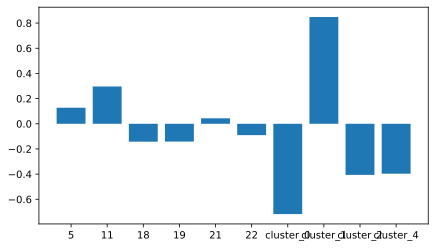

In [568]:
plt.bar(np.arange(len(w3)), w3)
plt.xticks(np.arange(len(w3)), cols3)

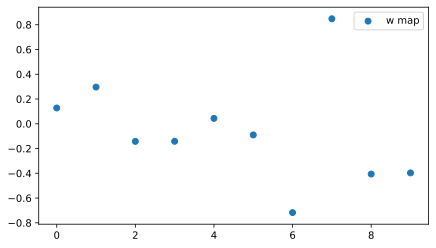

In [569]:
plot_weights(w3)

In [570]:
pred3 = predict_estimates_with_MF(X_test, w3, cols=cols3, cluster_centers=cluster_centers3, metric_mask=metric_mask3)

In [571]:
roc_auc_score(t_test, pred3)

0.6970087735514235

In [572]:
fpr, tpr, thresholds = metrics.roc_curve(t_test, pred3, pos_label=None)

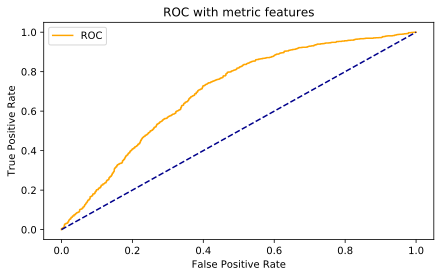

In [573]:
plot_roc_cur(fpr, tpr, title='ROC with metric features')

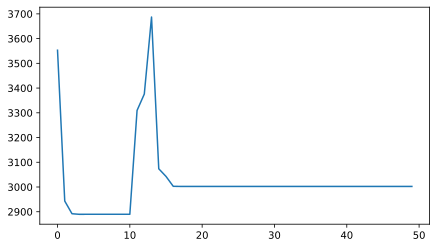

In [574]:
plt.plot(np.arange(len(costs3)),costs3)

In [508]:
model = LogisticRegression(random_state=0)
model.fit(X, T)

C:\Users\Irina\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [509]:
y_scores = model.predict_proba(X_test)[:, 1]

In [510]:
from sklearn.metrics import roc_auc_score
print('AUC-ROC', roc_auc_score(t_test, y_scores))

AUC-ROC 0.761931508199319


In [511]:
fpr, tpr, thresholds = metrics.roc_curve(t_test, y_scores, pos_label=None)

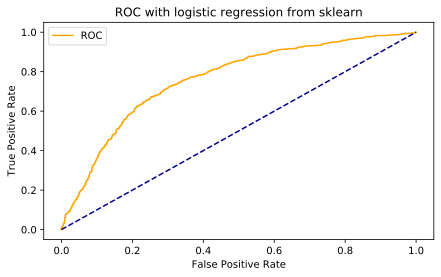

In [512]:
plot_roc_cur(fpr, tpr, title='ROC with logistic regression from sklearn')

In [487]:
coefs = np.abs(model.coef_[0])